# Import python packages

In [145]:
# import Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import linear_model
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, confusion_matrix
from scipy import stats
import warnings
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors
from scipy.stats import lognorm

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 14

# Read data

In [146]:
# load data
data = pd.read_csv('EQgate_geometries.csv')
feature = data["Feature"].unique()
grouped = data.groupby(data.Feature)

In [147]:
data.head()

FDHI ID   Earthquake          Date  Magnitude  Cumulative displacement  \
0        4  Balochistan  '2013-09-24'        7.7                    450.0   
1        4  Balochistan  '2013-09-24'        7.7                    450.0   
2        4  Balochistan  '2013-09-24'        7.7                    450.0   
3        4  Balochistan  '2013-09-24'        7.7                    450.0   
4        4  Balochistan  '2013-09-24'        7.7                    450.0   

         Style  Hypocenter lat  Hypocenter lon Feature Breached or unbreached  \
0  Strike-Slip          26.951          65.501    bend               breached   
1  Strike-Slip          26.951          65.501    bend               breached   
2  Strike-Slip          26.951          65.501    bend               breached   
3  Strike-Slip          26.951          65.501    bend               breached   
4  Strike-Slip          26.951          65.501    bend               breached   

   ... Location along rupture Total rupture length  Normalized location  \
0  ...          189199.980416        199115.277475             0.950203   
1  ...           77299.994037        199115.277475             0.388217   
2  ...          182299.981467        199115.277475             0.915550   
3  ...           86299.993386        199115.277475             0.433417   
4  ...            1499.999984        199115.277475             0.007533   

   Distance to epicenter  Distance to max slip        x1check       y1check  \
0           27391.059205          51817.592131  753335.921888  3.010388e+06   
1           85397.473473          59332.380134  687771.916748  2.923215e+06   
2           21242.879921          45046.534993  749551.207690  3.004671e+06   
3           76888.287686          50721.715777  696152.113435  2.926956e+06   
4          158879.048291         133521.282862  620459.092994  2.889118e+06   

   UTM zone   latcheck   loncheck  
0       41N  27.192918  65.557280  
1       41N  26.416788  64.882750  
2       41N  27.142044  65.517948  
3       41N  26.449417  64.967311  
4       41N  26.116270  64.204790  

[5 rows x 26 columns]

# Quickly play around with data
e.g. find largest restraining step-over

In [148]:
# grouped = grouped.get_group('bend')
# print(len(grouped))

# # # Filter rows where "Type (releasing or restraining)" is the type of interest
# # restraining_rows = grouped[grouped["Type (releasing or restraining)"] == 'restraining']
# # print(len(restraining_rows))

# # # Filter rows where "Breached or unbreached" is the type of interest
# breached_rows = grouped[grouped["Breached or unbreached"] == 'breached']
# max_length_or_angle = breached_rows["Length (m) or angle (deg)"].max()
# # # # Find location and value of the largest entry in "Length (m) or angle (deg)"
# # max_length_or_angle = breached_rows["Length (m) or angle (deg)"].max()
# largest_entry = breached_rows.loc[breached_rows["Length (m) or angle (deg)"].idxmax()]

# print(largest_entry)
# print(max_length_or_angle)

# functions required to analyze data and estimate passing probabilities

Function to generate logistic models for all of the earthquake gates in this study:

In [149]:
def bootstrap_errors(xfeature, BUbin, classweightb, ax, minx, maxx, length, n_iterations=10000):
    logistic_reg = []


    """
    This function calculates errors for the logistic fits based on bootstrapping

    """    
    for i in range(n_iterations):
        # Reset the index of the dataframes (if they are pandas DataFrames or Series)
        if isinstance(xfeature, pd.DataFrame):
            xfeature.reset_index(drop=True, inplace=True)
        if isinstance(BUbin, pd.DataFrame):
            BUbin.reset_index(drop=True, inplace=True)

        # Define the desired resampling ratio (e.g., 100% for bootstrap)
        resample_ratio = 1.0

        # Calculate the number of samples to keep based on the ratio
        num_samples_to_keep = int(len(xfeature) * resample_ratio)

        # Generate random indices for resampling with replacement
        selected_indices = np.random.choice(len(xfeature), num_samples_to_keep, replace=True)

        # Use the selected indices to extract the resampled data
        resampled_xfeature = xfeature.iloc[selected_indices]
        resampled_BUbin = BUbin.iloc[selected_indices]

        if len(resampled_BUbin.unique()) < 2:
           # print("Skipping iteration because there is only one class in BUbin")
            continue  # Skip the iteration of the outer loop

        # Fit a logistic regression model to the bootstrap sample
        
        probname = sklearn.linear_model.LogisticRegression(penalty='none', class_weight=classweightb).fit(
            np.atleast_2d(resampled_xfeature).T, resampled_BUbin
        )

        # Plot passing probability
        x = np.atleast_2d(np.linspace(minx, maxx, 10000)).T
        # ax.plot(x, probname.predict_proba(x)[:, 1], color=colorline, alpha=0.001)
        logistic_reg.append(probname.predict_proba(x)[:, 1])
    
    percentiles_2_5 = np.percentile(logistic_reg, 2.5, axis=0) # 34
    percentiles_97_5 = np.percentile(logistic_reg, 97.5, axis=0) # 68
    xi = np.linspace(minx, maxx, 10000)

    if length==True:
        ax.fill_between(10**xi, percentiles_2_5, percentiles_97_5, color='slategray', alpha=0.2)
    else:
        ax.fill_between(xi, percentiles_2_5, percentiles_97_5, color='slategray', alpha=0.2)

    #ax.fill_between(xi, percentiles_2_5, percentiles_97_5, color='slategray', alpha=0.2)
    return logistic_reg

In [150]:
def build_logistic_regression(
        groupid, 
        stress_typeYN, 
        length_or_angle, 
        class_weightb, 
        axesid,
        minx,
        maxx,
        colorline,
        xlabel,
        ptsize
        ):
    
    """
    This function builds logistic regressions for earthquake gates, based on the groups mapped as breached and unbreached.

    """   
    
    EQgate = grouped.get_group(groupid)

    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        feature = group['Length (m) or angle (deg)']
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['unbreached']

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        feature = group['Length (m) or angle (deg)']
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['unbreached']
    
    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        feature = group['Length (m) or angle (deg)']
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['unbreached']

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        feature = group['Length (m) or angle (deg)']
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['unbreached']

    else:
        group = EQgate 
        feature = EQgate['Length (m) or angle (deg)']
        group['logfeature'] = np.log10(group['Length (m) or angle (deg)'].astype('float'))
        BUbin = pd.get_dummies(EQgate['Breached or unbreached'])
        BUbin = BUbin['unbreached']
    
    if length_or_angle == 'length':
        group['logfeature'] = np.log10(group['Length (m) or angle (deg)'].astype('float')) 
        xfeature = group['logfeature']
        minx = np.log10(minx)
        maxx = np.log10(maxx)

    elif length_or_angle == 'angle':
        group['logfeature'] = np.log10(group['Length (m) or angle (deg)'])
        xfeature = group['Length (m) or angle (deg)']
        # minx = np.log10(minx)
        # maxx = np.log10(maxx)
    else: 
        KeyError("Feature must include a length or an angle")


    palette = {'breached': 'darkseagreen', 'unbreached': 'firebrick'}
    
    if max(group['Length (m) or angle (deg)'])>90:
            sns.swarmplot(
            data=group,
            #x = 'logfeature',
            x='Length (m) or angle (deg)',
            y='Breached or unbreached',
            ax=axesid,size=ptsize,
            hue="Breached or unbreached",
            palette=palette,alpha=0.5
        )
    else:  
        sns.swarmplot(
            data=group,
            x='Length (m) or angle (deg)',
            y='Breached or unbreached',
            ax=axesid,size=ptsize,
            hue="Breached or unbreached",
            palette=palette,alpha=0.5
        )

    if max(group['Length (m) or angle (deg)'])>90:
        bootstrap_errors(xfeature, BUbin, class_weightb, axesid, minx, maxx, True)
    else: 
        bootstrap_errors(xfeature, BUbin, class_weightb, axesid, minx, maxx, False)

    probname = sklearn.linear_model.LogisticRegression(penalty='none',class_weight=class_weightb).fit(np.atleast_2d(xfeature).T,BUbin)

    # tests
    acc = accuracy_score(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    pre = precision_score(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    f1 = f1_score(BUbin, probname.predict(np.atleast_2d(xfeature).T))
    roc =  roc_auc_score(BUbin, probname.predict_proba(np.atleast_2d(xfeature).T)[:,1])
    confusion_matrixi = confusion_matrix(BUbin, probname.predict(np.atleast_2d(xfeature).T))

    x = np.atleast_2d(np.linspace(minx, maxx, 10000)).T

    if max(group['Length (m) or angle (deg)'])>90:
        axesid.plot(10**x,probname.predict_proba(x)[:,1],color = colorline)
        axesid.text(10**x[-10], -0.1, f'ROC={roc:.2f}', ha='right', va='top',fontsize=14)
        axesid.set_xscale('log')
    else:
        axesid.text(x[-10], -0.1, f'ROC={roc:.2f}', ha='right', va='top',fontsize=14)
        # axesid.text(x[-10], 0.1, r'$P_{50}$=' + str(int(x_at_threshold)) + '$^{\circ}$', ha='right', va='top', fontsize=14)
        axesid.plot(x,probname.predict_proba(x)[:,1],color = colorline)

    axesid.set_ylabel('Passing probability')
    axesid.set_xlabel(xlabel)
    axesid.set_yticklabels(["Breached", "Unbreached"],rotation=90,va='center')
    axesid.get_legend().remove()

    return probname, acc, pre, f1, roc, confusion_matrixi, BUbin, xfeature 

Function required to build logistic model for double bend lengths (both hypothenuse and equivalent step-over length):

In [151]:
def build_regression_double_bend_length(groupid,stress_typeYN,feature_type,axesid,minx,maxx,xlabel,ptsize):

    """
    This function calculates a logistic regression for a set of earthquake gate double bend length metrics from surface ruptures and plots the results.

    """    
    EQgate = grouped.get_group(groupid)

    if stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        feature = group[feature_type]
        BUbin = pd.get_dummies(group['Breached or unbreached'])
        BUbin = BUbin['breached']
        group['logfeature'] = np.log10(group['Length (m) or angle (deg)'].astype('float')) 
        xfeature = group['logfeature']
        minx = np.log10(minx)
        maxx = np.log10(maxx)

    palette = {'breached': 'darkseagreen', 'unbreached': 'firebrick'}
    if max(xfeature)>90:
        sns.swarmplot(data=group,x=10**feature_type,y='Breached or unbreached',ax=axesid,size=ptsize,hue="Breached or unbreached",palette=palette,alpha=0.5)
    else:
        sns.swarmplot(data=group,x=feature_type,y='Breached or unbreached',ax=axesid,size=ptsize,hue="Breached or unbreached",palette=palette,alpha=0.5)

    axesid.set_xscale('log')
    axesid.set_xlabel(xlabel)
    axesid.set_yticklabels(["Breached", "Unbreached"],rotation=90,va='center')
    axesid.get_legend().remove()

    return BUbin, xfeature 


Function to generate CDFs for all of the earthquake gates in this study. Separated into breached and unbreached categories, and restraining and releasing when available. 

In [152]:
# make CDFs
def build_cdf(groupid, stress_typeYN, length_or_angle, colorB,colorU, axesid,xlabel,labelB, labelU):

    """
    This function generates CDFs for the geometry measured for each earthquake gate, separated into breached and unbreached features and restraining and releasing when available. 

    """
    EQgate = grouped.get_group(groupid)

    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif groupid == 'strand':
        grouped_BU = EQgate.groupby(EQgate["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('breached')

    else: 
        group = EQgate
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
        
    if length_or_angle == 'length':
        xvals_U = np.log10(xvals_U['Length (m) or angle (deg)'])
        xvals_B = np.log10(xvals_B['Length (m) or angle (deg)'])
        #xvals_U = np.log10(xvals_U['Spacing double bend (m)'])
        #xvals_B = np.log10(xvals_B['Spacing double bend (m)'])
        

    elif length_or_angle == 'angle':
        xvals_B = xvals_B['Length (m) or angle (deg)']
        xvals_U = xvals_U['Length (m) or angle (deg)']

    else: 
        KeyError("Feature must include a length or an angle")

    # sort the data:
    sortB = np.sort(xvals_B)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_B)) / (len(xvals_B) - 1) 
    sns.ecdfplot(sortB,c=colorB,label=labelB,ax=axesid) 
    axesid.set_xlabel(xlabel)
    sortU = np.sort(xvals_U)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_U)) / (len(xvals_U) - 1) 
    #axesid.plot(sortU,p,c=colorU,label=labelU) 
    sns.ecdfplot(sortU,c=colorU,label=labelU,ax=axesid)
    axesid.set_xlabel(xlabel)
    axesid.set_ylabel('Proportion')
    axesid.legend()

In [153]:
# make CDFs
def build_cdf_lognorm(groupid, stress_typeYN, length_or_angle, colorB, colorU, axesid,xlabel,labelB, labelU):

    """
    This function generates CDFs for the geometry measured for each earthquake gate, separated into breached and unbreached features and restraining and releasing when available. We then fit log normal CDFs to the ECDF.

    """
    EQgate = grouped.get_group(groupid)

    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif groupid == 'strand':
        grouped_BU = EQgate.groupby(EQgate["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('breached')

    else: 
        group = EQgate
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
        
    if length_or_angle == 'length':
        xvals_U = xvals_U['Length (m) or angle (deg)']
        xvals_B = xvals_B['Length (m) or angle (deg)']
        #xvals_U = np.log10(xvals_U['Spacing double bend (m)'])
        #xvals_B = np.log10(xvals_B['Spacing double bend (m)'])
        

    elif length_or_angle == 'angle':
        xvals_B = xvals_B['Length (m) or angle (deg)']
        xvals_U = xvals_U['Length (m) or angle (deg)']

    else: 
        KeyError("Feature must include a length or an angle")

    # log normal fit breache
    sortB = np.sort(xvals_B)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_B)) / (len(xvals_B) - 1) 
    sns.ecdfplot(sortB,c=colorB,label=labelB,ax=axesid) 
    axesid.set_xlabel(xlabel)

    # log normal fit breached
    yvals = np.arange(len(sortB)) / float(len(sortB)-1)
    shape, loc, scale = lognorm.fit(sortB, floc=0, f0=1-yvals[-1])
    xvals = np.linspace(min(sortB), max(sortB), 100)
    cdf_fitted = lognorm.cdf(xvals, shape, loc, scale)
    axesid.plot(xvals, cdf_fitted, color=colorB,linestyle=':')  

    sortU = np.sort(xvals_U)
    yvals = np.arange(len(sortU)) / float(len(sortU)-1)
    shape, loc, scale = lognorm.fit(sortU, floc=0, f0=1-yvals[-1])
    xvals = np.linspace(min(sortU), max(sortU), 100)
    cdf_fitted = lognorm.cdf(xvals, shape, loc, scale)

    if max(xvals)>90:
        sns.ecdfplot(sortU,c=colorU,label=labelU,ax=axesid)
        axesid.plot(xvals, cdf_fitted, color=colorU,linestyle=':') 
        axesid.set_xscale('log')
    else: 
        sns.ecdfplot(sortU,c=colorU,label=labelU,ax=axesid)
        axesid.plot(xvals, cdf_fitted, color=colorU,linestyle=':') 

    axesid.set_xlabel(xlabel)
    axesid.set_ylabel('Proportion')
    axesid.legend(fontsize=8)

Function to generate pdfs associated with the cdfs above:

In [154]:
# make PDFs
def build_pdf(groupid, stress_typeYN, length_or_angle, colorB,colorU, axesid,xlabel,labelB, labelU):

    """
    This function calculates PFDs for each earthquake gate geometry.
    """
    EQgate = grouped.get_group(groupid)

    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif groupid == 'strand':
        grouped_BU = EQgate.groupby(EQgate["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('breached')

    else: 
        group = EQgate
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
        
    if length_or_angle == 'length':
        xvals_U = np.log10(xvals_U['Length (m) or angle (deg)'])
        xvals_B = np.log10(xvals_B['Length (m) or angle (deg)'])
        

    elif length_or_angle == 'angle':
        xvals_B = xvals_B['Length (m) or angle (deg)']
        xvals_U = xvals_U['Length (m) or angle (deg)']

    else: 
        KeyError("Feature must include a length or an angle")

    sns.kdeplot(xvals_U,c=colorU,label=labelU,ax=axesid)
    sns.kdeplot(xvals_B,c=colorB,label=labelB,ax=axesid)
    
    axesid.set_xlabel(xlabel)
    axesid.set_ylabel('Proportion')
    axesid.legend()

CDFs for double bend lengths (hypothenuse and equivalent bend angle):

In [155]:
# make CDFs bend lengths
def build_cdf_bend_lengths(groupid, stress_typeYN, featuretype, colorB,colorU, axesid,xlabel,labelB, labelU):

    """

    This function generates CDFs for the bend length and proxy step-over length for double bends, separated into breached and unbreached groups

    """
    EQgate = grouped.get_group(groupid)

    if stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
    
        xvals_U = xvals_U[featuretype]
        xvals_B = xvals_B[featuretype]


    else: 
        KeyError("This function only works for double bends")

    # sort the data:
    sortB = np.sort(xvals_B)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_B)) / (len(xvals_B) - 1) 
    sns.ecdfplot(sortB,c=colorB,label=labelB,ax=axesid) 
    axesid.set_xlabel(xlabel)
    sortU = np.sort(xvals_U)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(xvals_U)) / (len(xvals_U) - 1) 
    #axesid.plot(sortU,p,c=colorU,label=labelU) 
    sns.ecdfplot(sortU,c=colorU,label=labelU,ax=axesid)
    axesid.set_xlabel(xlabel)
    axesid.set_xscale('log')
    axesid.set_ylabel('Proportion')
    axesid.legend()

Run a ks test to determine whether breached and unbreached populations are statistically significantly different:

In [156]:
def kstest_variables(groupid, stress_typeYN, length_or_angle):

    """
    This function runs a ks test through two populations to compare whether they are drawn from the same distribution.
    """

    EQgate = grouped.get_group(groupid)
    
    if stress_typeYN  == 'restraining':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('restraining')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN  == 'releasing':
        grouped_stress = EQgate.groupby(EQgate["Type (releasing or restraining)"])
        group = grouped_stress.get_group('releasing')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('single')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')

    elif stress_typeYN == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        group = grouped_stress.get_group('double')
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
    
    elif stress_typeYN == 'releasing_restraining_breached':
        grouped_stress = EQgate.groupby(EQgate["Breached or unbreached"])
        group = grouped_stress.get_group('breached')
        grouped_BU = group.groupby(group["Type (releasing or restraining)"])
        xvals_B = grouped_BU.get_group('releasing')
        xvals_U = grouped_BU.get_group('restraining')

    elif stress_typeYN == 'releasing_restraining_unbreached':
        grouped_stress = EQgate.groupby(EQgate["Breached or unbreached"])
        group = grouped_stress.get_group('unbreached')
        grouped_BU = group.groupby(group["Type (releasing or restraining)"])
        xvals_B = grouped_BU.get_group('releasing')
        xvals_U = grouped_BU.get_group('restraining')


    elif groupid == 'strand':
        grouped_BU = EQgate.groupby(EQgate["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('breached')

    else: 
        group = EQgate
        grouped_BU = group.groupby(group["Breached or unbreached"])
        xvals_B = grouped_BU.get_group('breached')
        xvals_U = grouped_BU.get_group('unbreached')
        
    if length_or_angle == 'length':
        xvals_U = np.log10(xvals_U['Length (m) or angle (deg)'])
        xvals_B = np.log10(xvals_B['Length (m) or angle (deg)'])
 #       xvals_U = np.log10(xvals_U['Spacing double bend (m)'])
 #       xvals_B = np.log10(xvals_B['Spacing double bend (m)'])

    elif length_or_angle == 'angle':
        xvals_B = xvals_B['Length (m) or angle (deg)']
        xvals_U = xvals_U['Length (m) or angle (deg)']

    else: 
        KeyError("Feature must include a length or an angle")
    
    return  stats.kstest(xvals_B, xvals_U)

### Earthquake gate distributions

CDFs

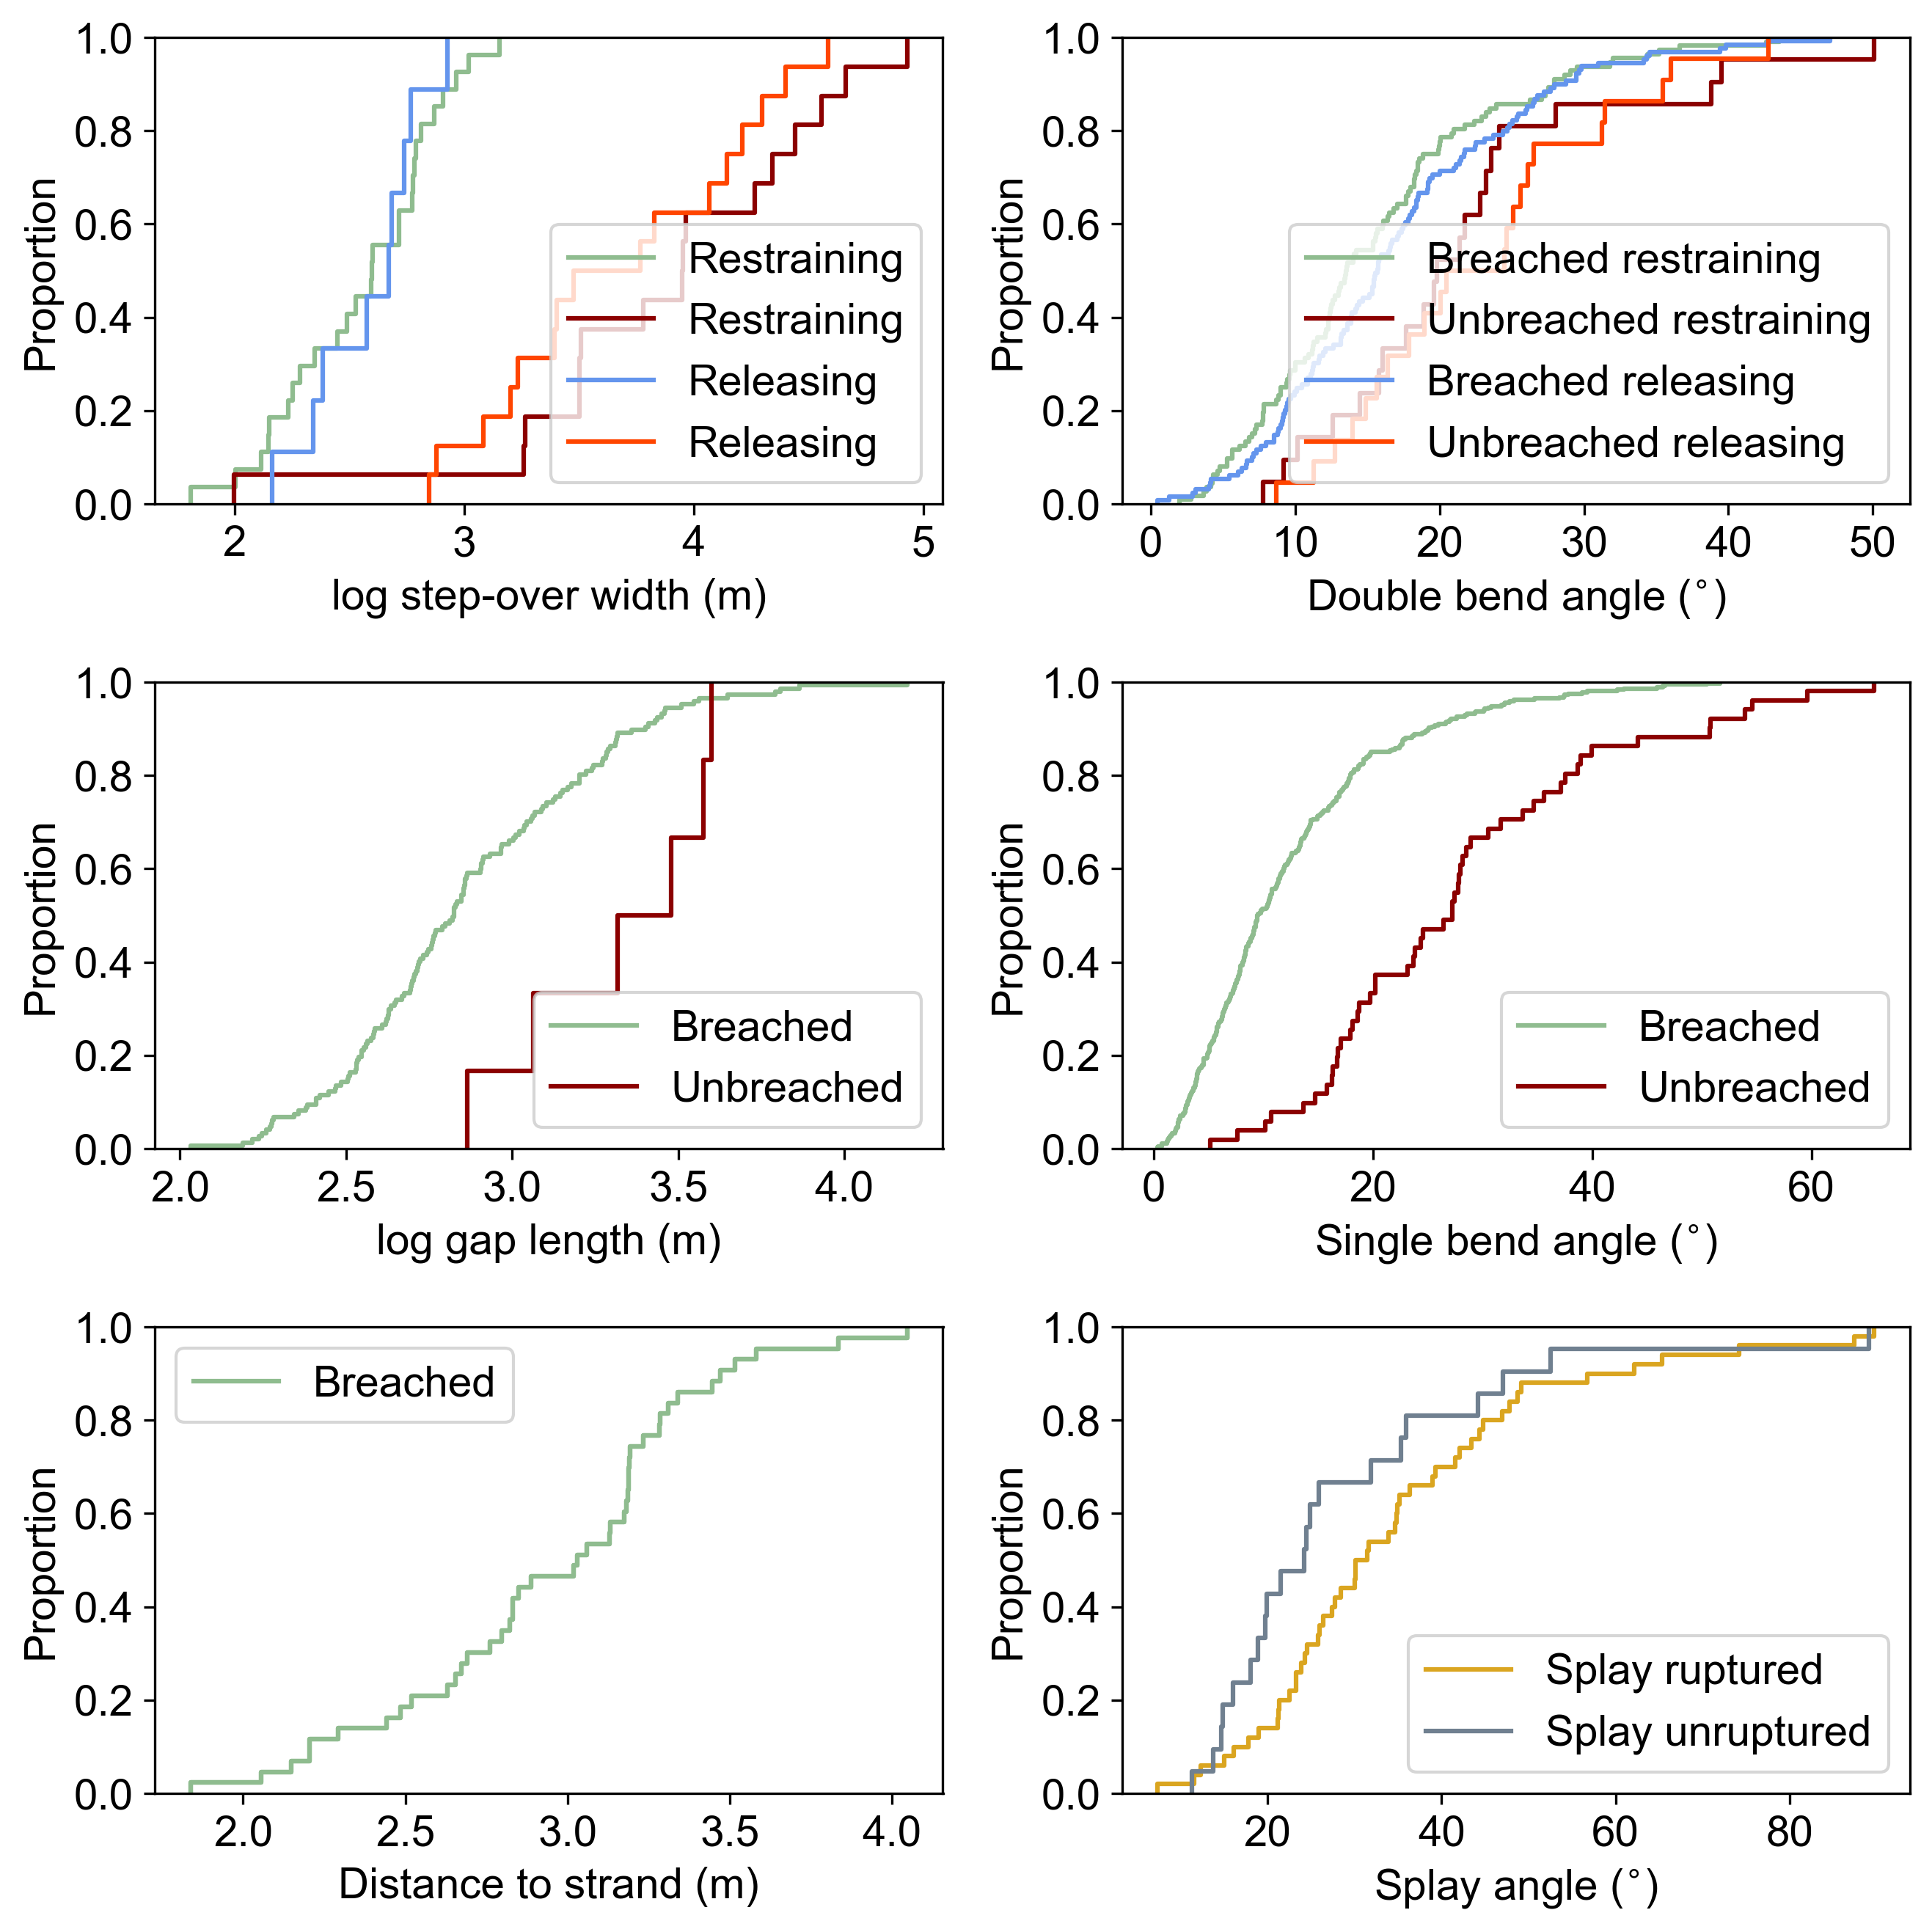

In [157]:
fig, axes = plt.subplots(3,2,figsize=(9,9))

build_cdf('stepover', 'restraining', 'length', 'darkseagreen','darkred',axes[0,0] ,'log step-over width (m)','Restraining', 'Restraining')
build_cdf('stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'log step-over width (m)','Releasing', 'Releasing')
build_cdf('bend', 'restraining', 'angle','darkseagreen','darkred',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached restraining', 'Unbreached restraining')
build_cdf('bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached releasing', 'Unbreached releasing')
build_cdf('gap', 'none', 'length', 'darkseagreen','darkred',axes[1,0] , 'log gap length (m)','Breached', 'Unbreached')
build_cdf('bend', 'single', 'angle', 'darkseagreen','darkred',axes[1,1] ,'Single bend angle ($^{\circ}$)','Breached', 'Unbreached')
build_cdf('splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($^{\circ}$)','Splay ruptured', 'Splay unruptured')
build_cdf('strand', 'none', 'length', 'darkseagreen','darkseagreen',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/CDFs.pdf')
plt.show()



log-normal distribution fitting

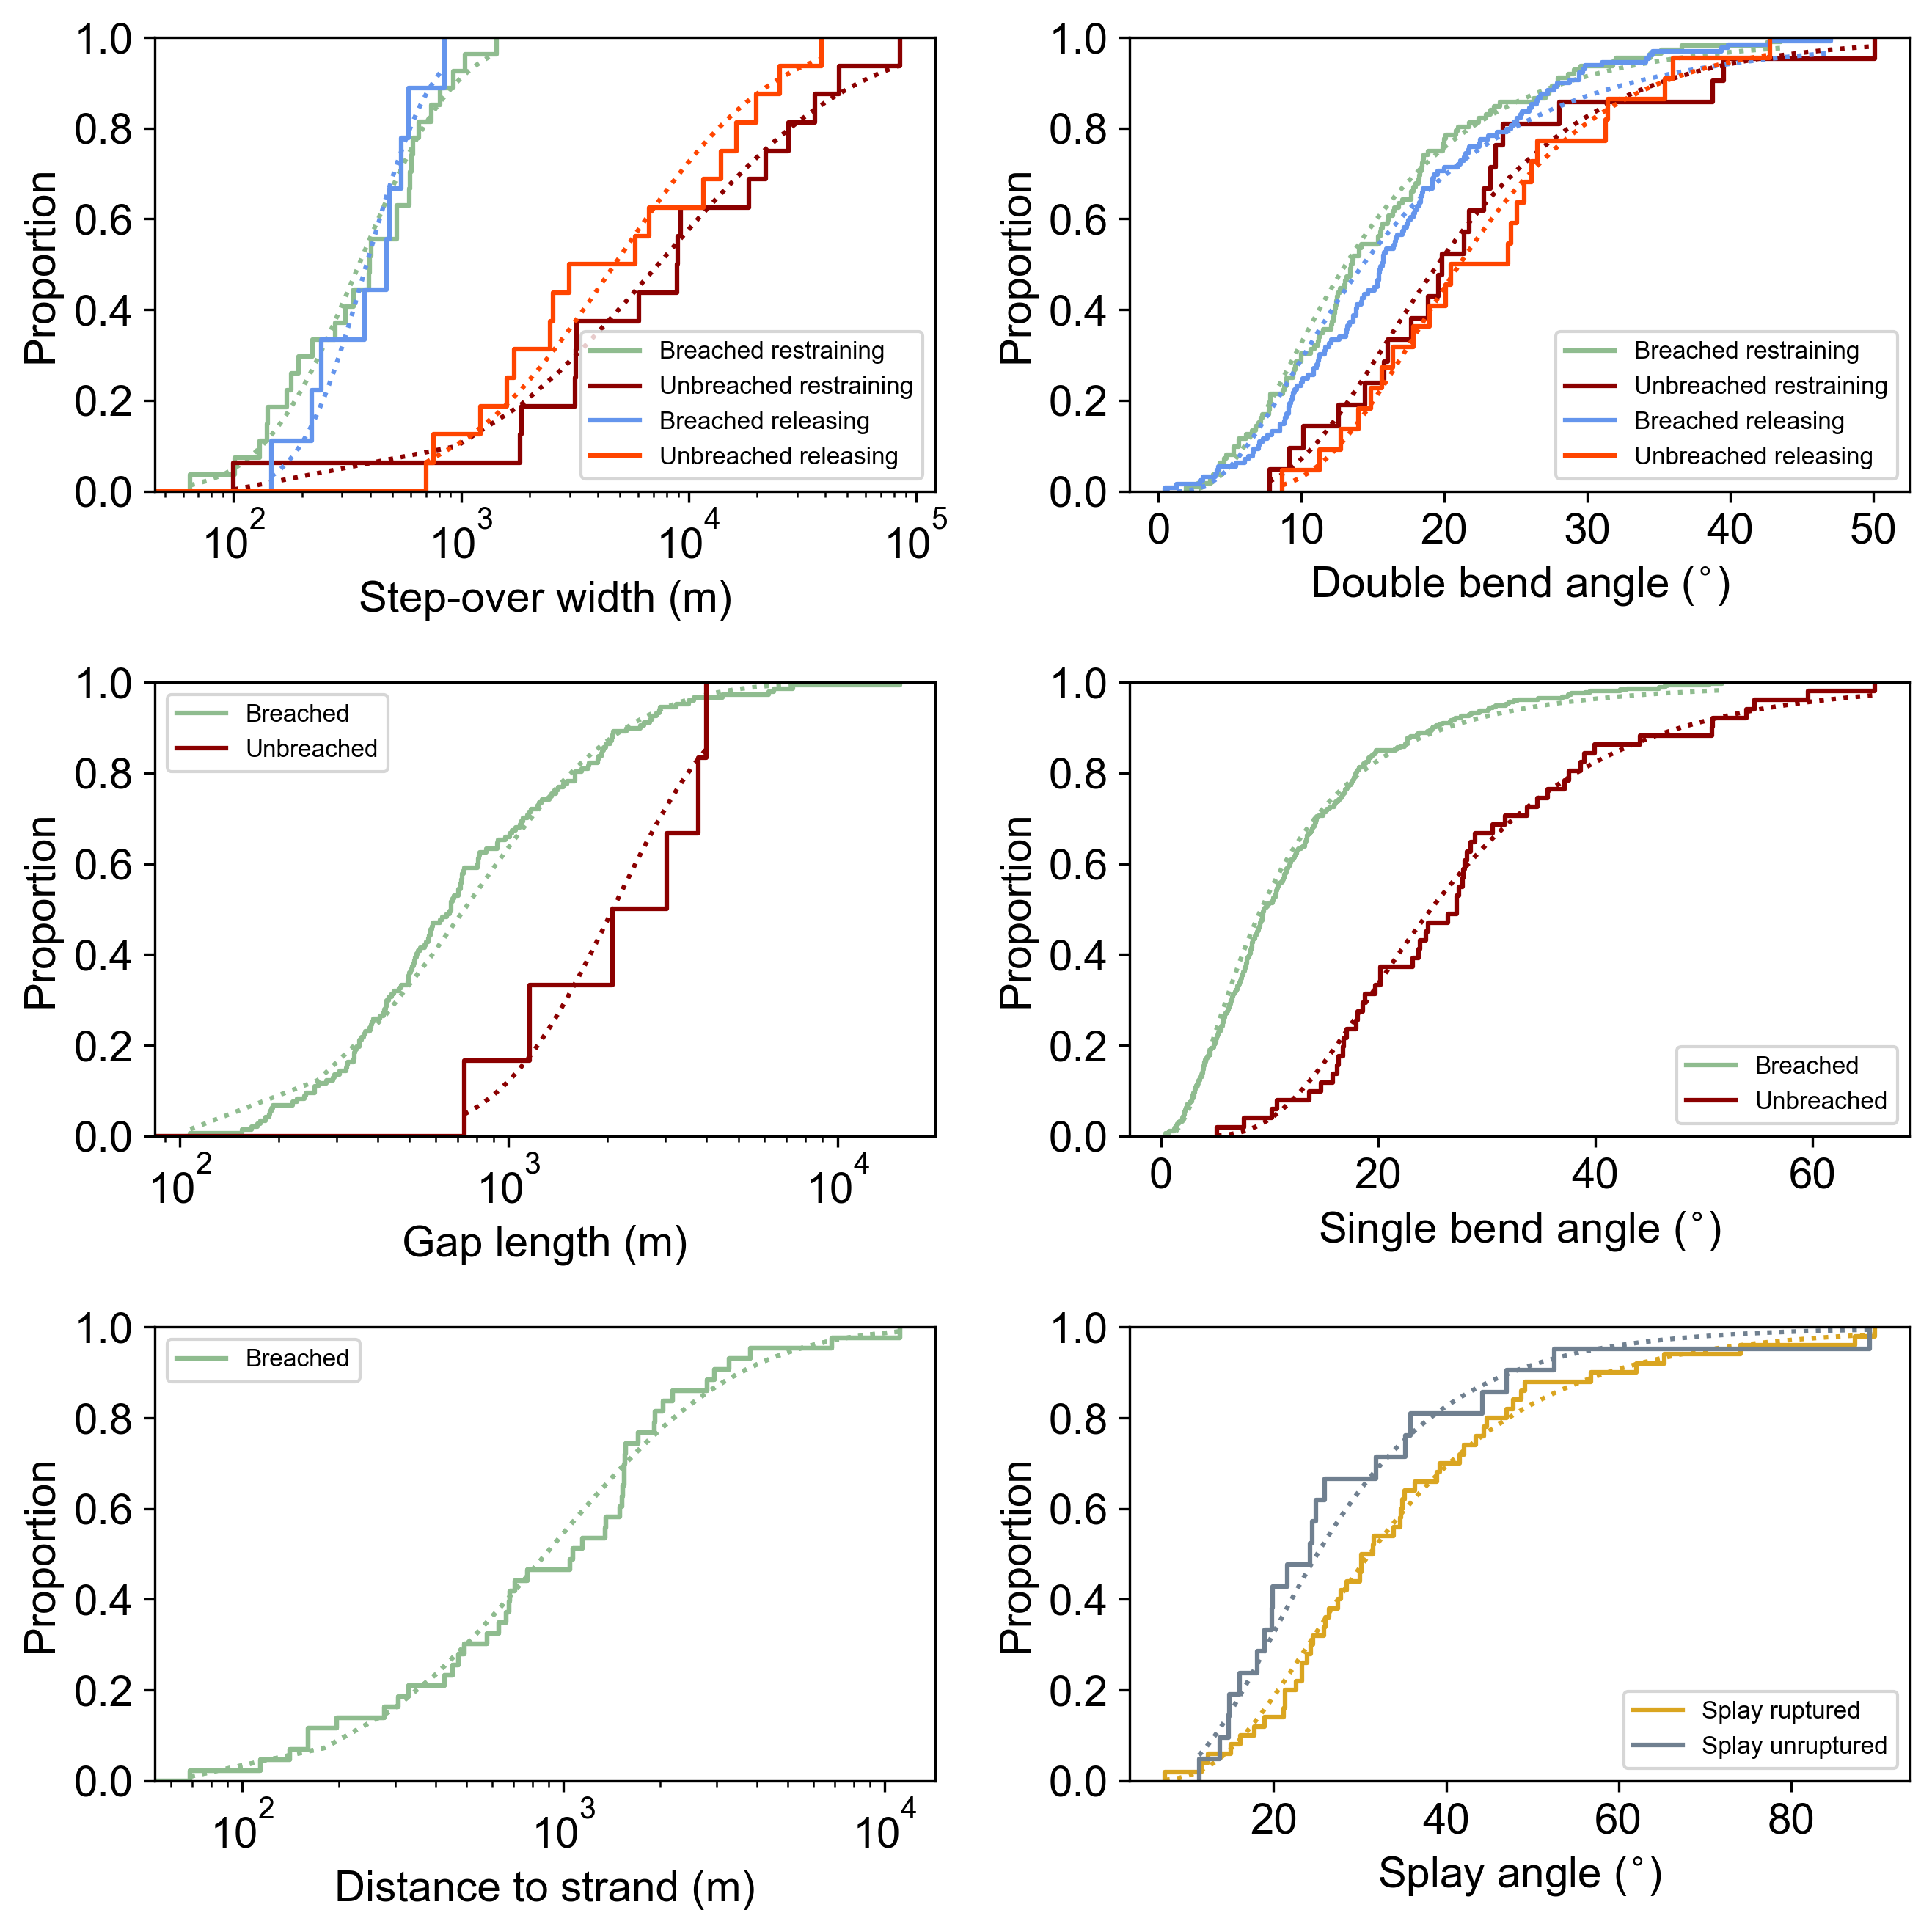

In [158]:
fig, axes = plt.subplots(3,2,figsize=(9,9),dpi=300)

build_cdf_lognorm('stepover', 'restraining', 'length', 'darkseagreen','darkred',axes[0,0] ,'Step-over width (m)','Breached restraining', 'Unbreached restraining')
build_cdf_lognorm('stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'Step-over width (m)','Breached releasing', 'Unbreached releasing')
build_cdf_lognorm('bend', 'restraining', 'angle','darkseagreen','darkred',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached restraining', 'Unbreached restraining')
build_cdf_lognorm('bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached releasing', 'Unbreached releasing')
build_cdf_lognorm('gap', 'none', 'length', 'darkseagreen','darkred',axes[1,0] , 'Gap length (m)','Breached', 'Unbreached')
build_cdf_lognorm('bend', 'single', 'angle', 'darkseagreen','darkred',axes[1,1] ,'Single bend angle ($^{\circ}$)','Breached', 'Unbreached')
build_cdf_lognorm('splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($^{\circ}$)','Splay ruptured', 'Splay unruptured')
build_cdf_lognorm('strand', 'none', 'length', 'darkseagreen','darkseagreen',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/lognorm_CDFs.pdf')
plt.show()



PDFs

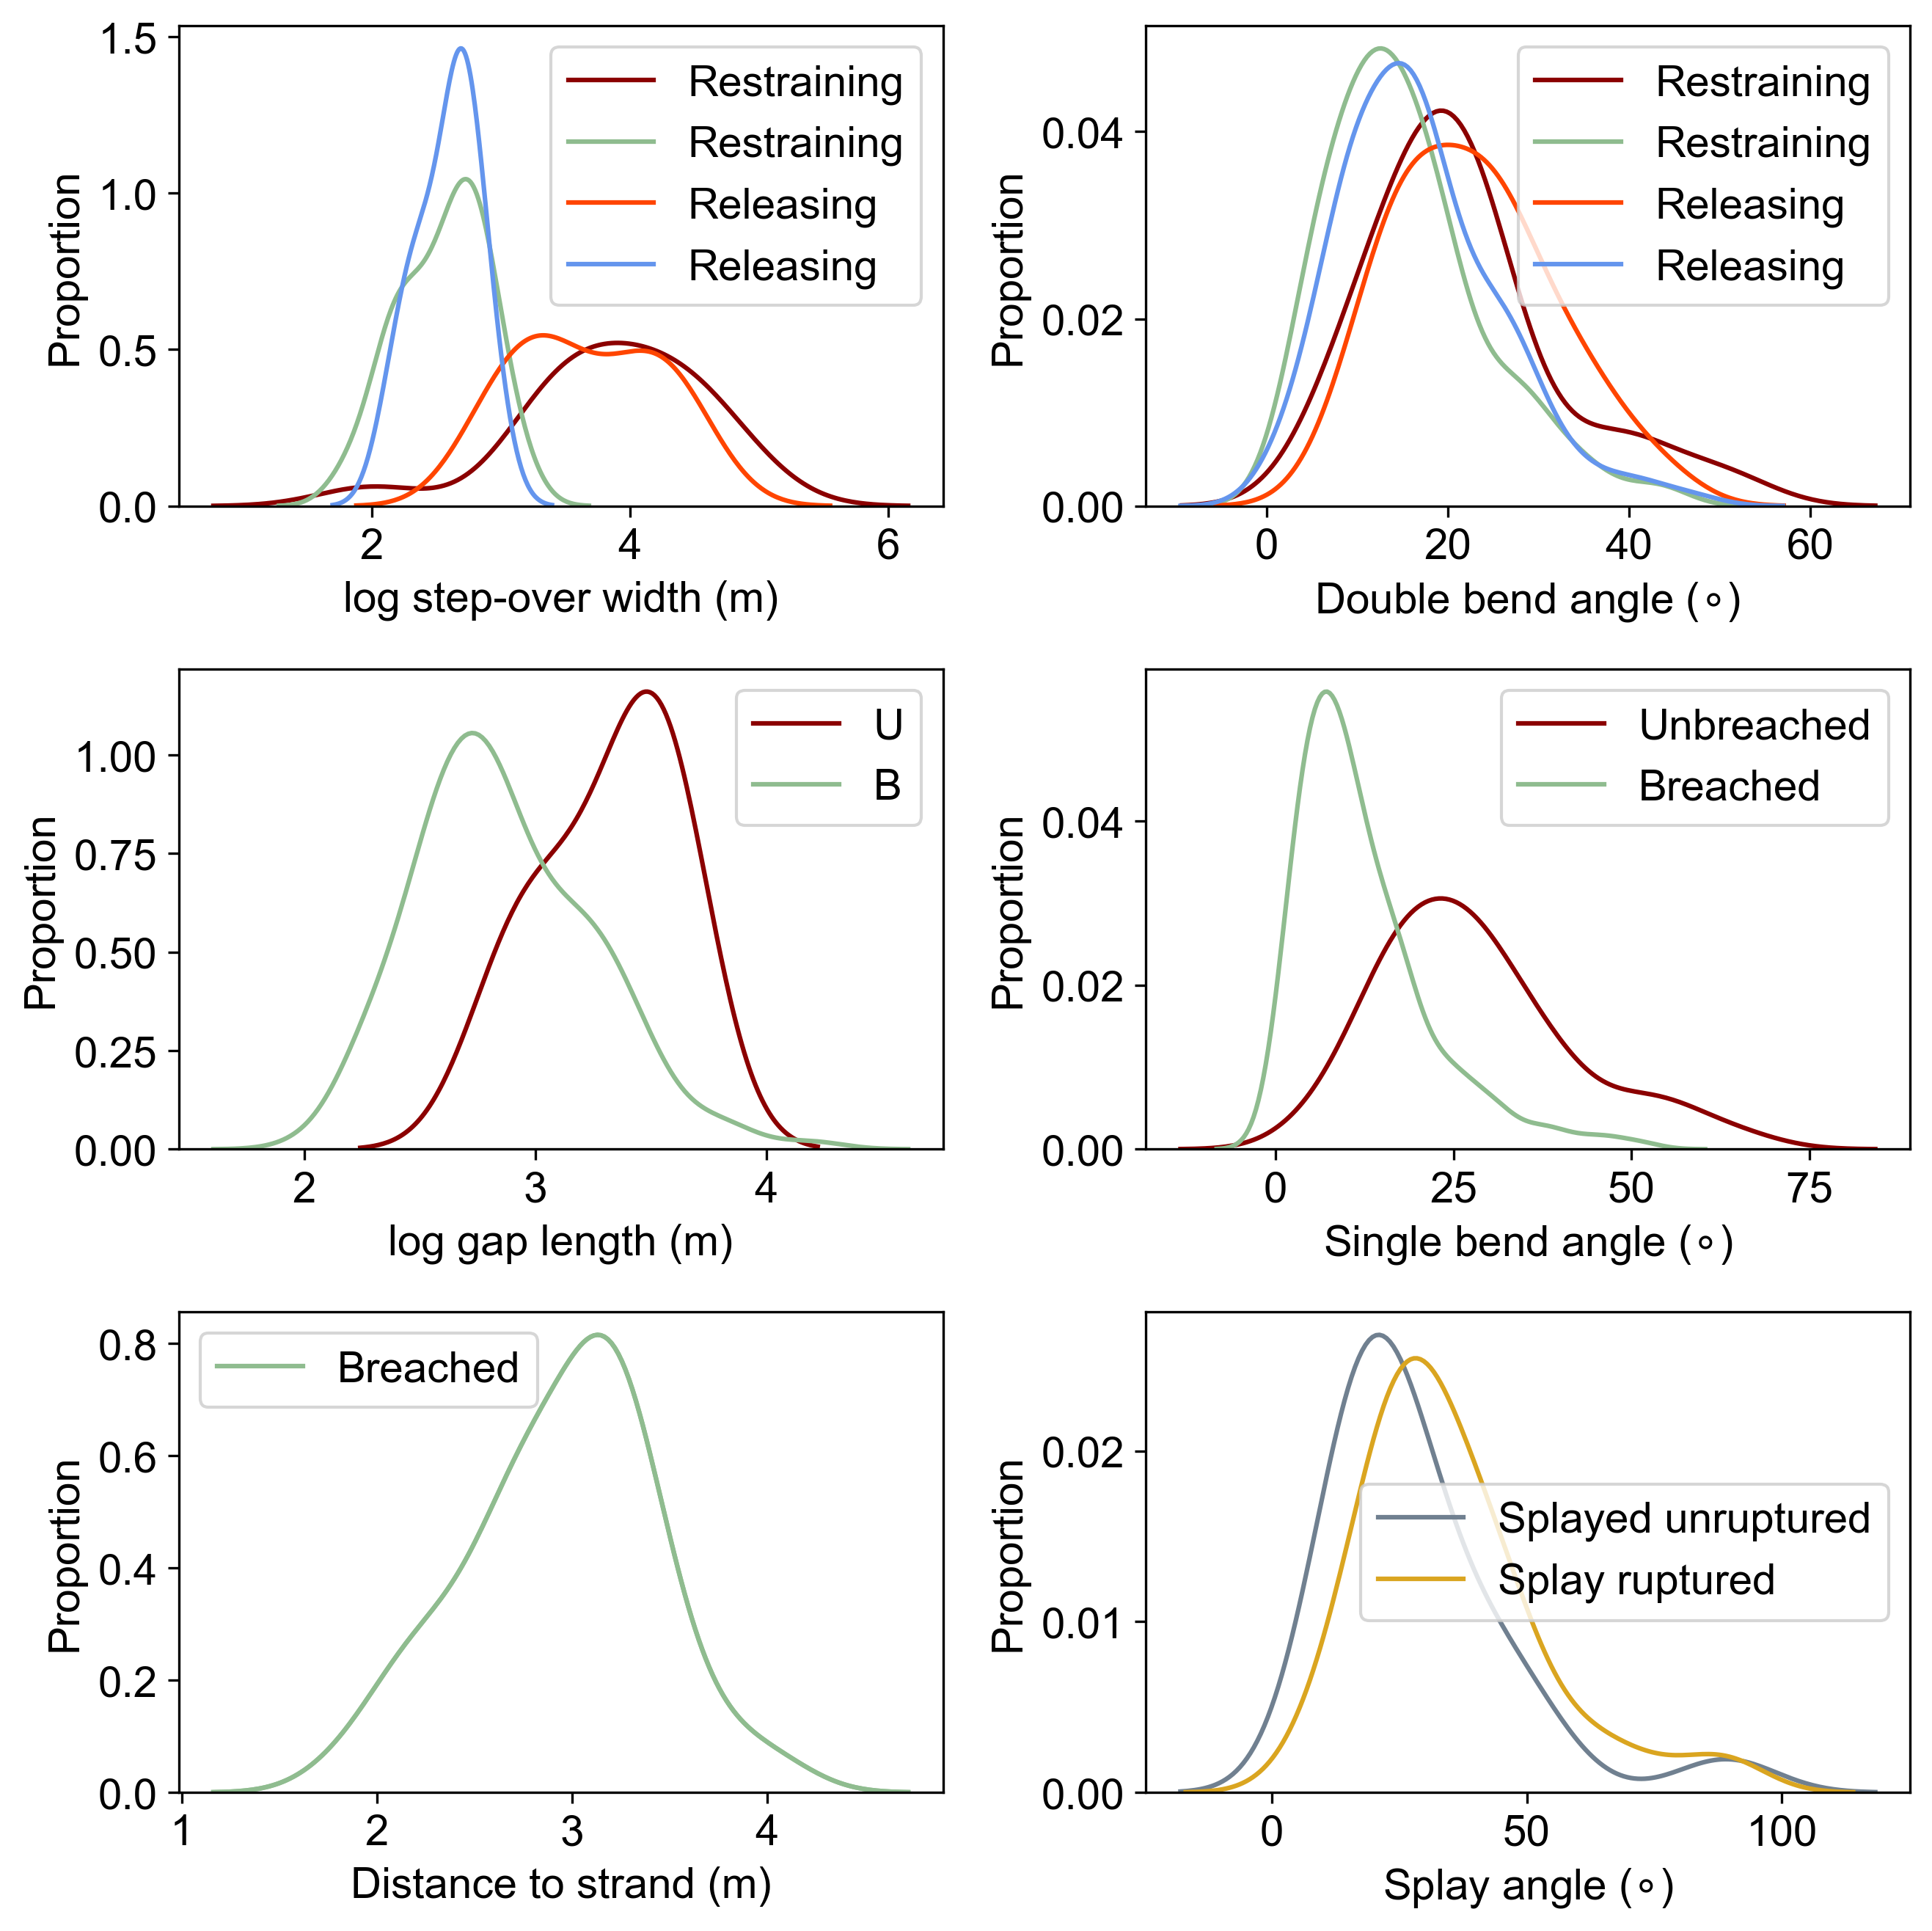

In [159]:
fig, axes = plt.subplots(3,2,figsize=(9,9))

build_pdf('stepover', 'restraining', 'length', 'darkseagreen','darkred',axes[0,0] ,'log step-over width (m)','Restraining', 'Restraining')
build_pdf('stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'log step-over width (m)','Releasing', 'Releasing')
build_pdf('bend', 'restraining', 'angle','darkseagreen','darkred',axes[0,1] ,'Double bend angle ($\circ$)','Restraining', 'Restraining')
build_pdf('bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($\circ$)','Releasing', 'Releasing')
build_pdf('gap', 'none', 'length', 'darkseagreen','darkred',axes[1,0] , 'log gap length (m)','B', 'U')
build_pdf('bend', 'single', 'angle', 'darkseagreen','darkred',axes[1,1] ,'Single bend angle ($\circ$)','Breached', 'Unbreached')
build_pdf('splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($\circ$)','Splay ruptured', 'Splayed unruptured')
build_pdf('strand', 'none', 'length', 'darkseagreen','darkseagreen',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/PDFs.pdf')
plt.show()



ks tests

In [160]:
# ks test for populations of earthquake gates
double_bend_ks = kstest_variables('bend', 'double', 'angle')
print('double_bend_ks')
print(double_bend_ks)

single_bend_ks = kstest_variables('bend', 'single', 'angle')
print('single_bend_ks')
print(single_bend_ks)

stepover_ks= kstest_variables('stepover', 'none', 'length')
print('stepover_ks')
print(stepover_ks)


gap_ks = kstest_variables('gap', '', 'length')
print('gap_ks')
print(gap_ks)

splay_ks = kstest_variables('splay', 'none', 'angle')
print('splay_ks')
print(splay_ks)

releasing_restraining_unbreached_bend_ks = kstest_variables('bend', 'releasing_restraining_unbreached', 'angle')
print('releasing_restraining_unbreached_bend_ks')
print(releasing_restraining_unbreached_bend_ks)

releasing_restraining_breached_bend_ks = kstest_variables('bend', 'releasing_restraining_breached', 'angle')
print('releasing_restraining_breached_bend_ks')
print(releasing_restraining_breached_bend_ks)

releasing_restraining_breached_stepover_ks = kstest_variables('stepover', 'releasing_restraining_breached', 'length')
print('releasing_restraining_breached_stepover_ks')
print(releasing_restraining_breached_stepover_ks)

releasing_restraining_unbreached_stepover_ks = kstest_variables('stepover', 'releasing_restraining_unbreached', 'length')
print('releasing_restraining_unbreached_stepover_ks')
print(releasing_restraining_unbreached_stepover_ks)

double_bend_ks
KstestResult(statistic=0.30901639344262294, pvalue=0.0010143572604503406, statistic_location=18.8404497634911, statistic_sign=1)
single_bend_ks
KstestResult(statistic=0.6084825234441603, pvalue=2.987200172137618e-16, statistic_location=14.5420634348074, statistic_sign=1)
stepover_ks
KstestResult(statistic=0.8784722222222222, pvalue=5.85136471753042e-14, statistic_location=3.0186515385142907, statistic_sign=1)
gap_ks
KstestResult(statistic=0.5918367346938775, pvalue=0.01937621906188794, statistic_location=2.8652469727228658, statistic_sign=1)
splay_ks
KstestResult(statistic=0.32666666666666666, pvalue=0.06517251106377434, statistic_location=25.8837228358785, statistic_sign=-1)
releasing_restraining_unbreached_bend_ks
KstestResult(statistic=0.30952380952380953, pvalue=0.18592563139252566, statistic_location=24.1180926718903, statistic_sign=-1)
releasing_restraining_breached_bend_ks
KstestResult(statistic=0.13683554817275748, pvalue=0.18811420989596248, statistic_location=1

# Plot passing probabilities and earthquake gate analysis

Logistic models

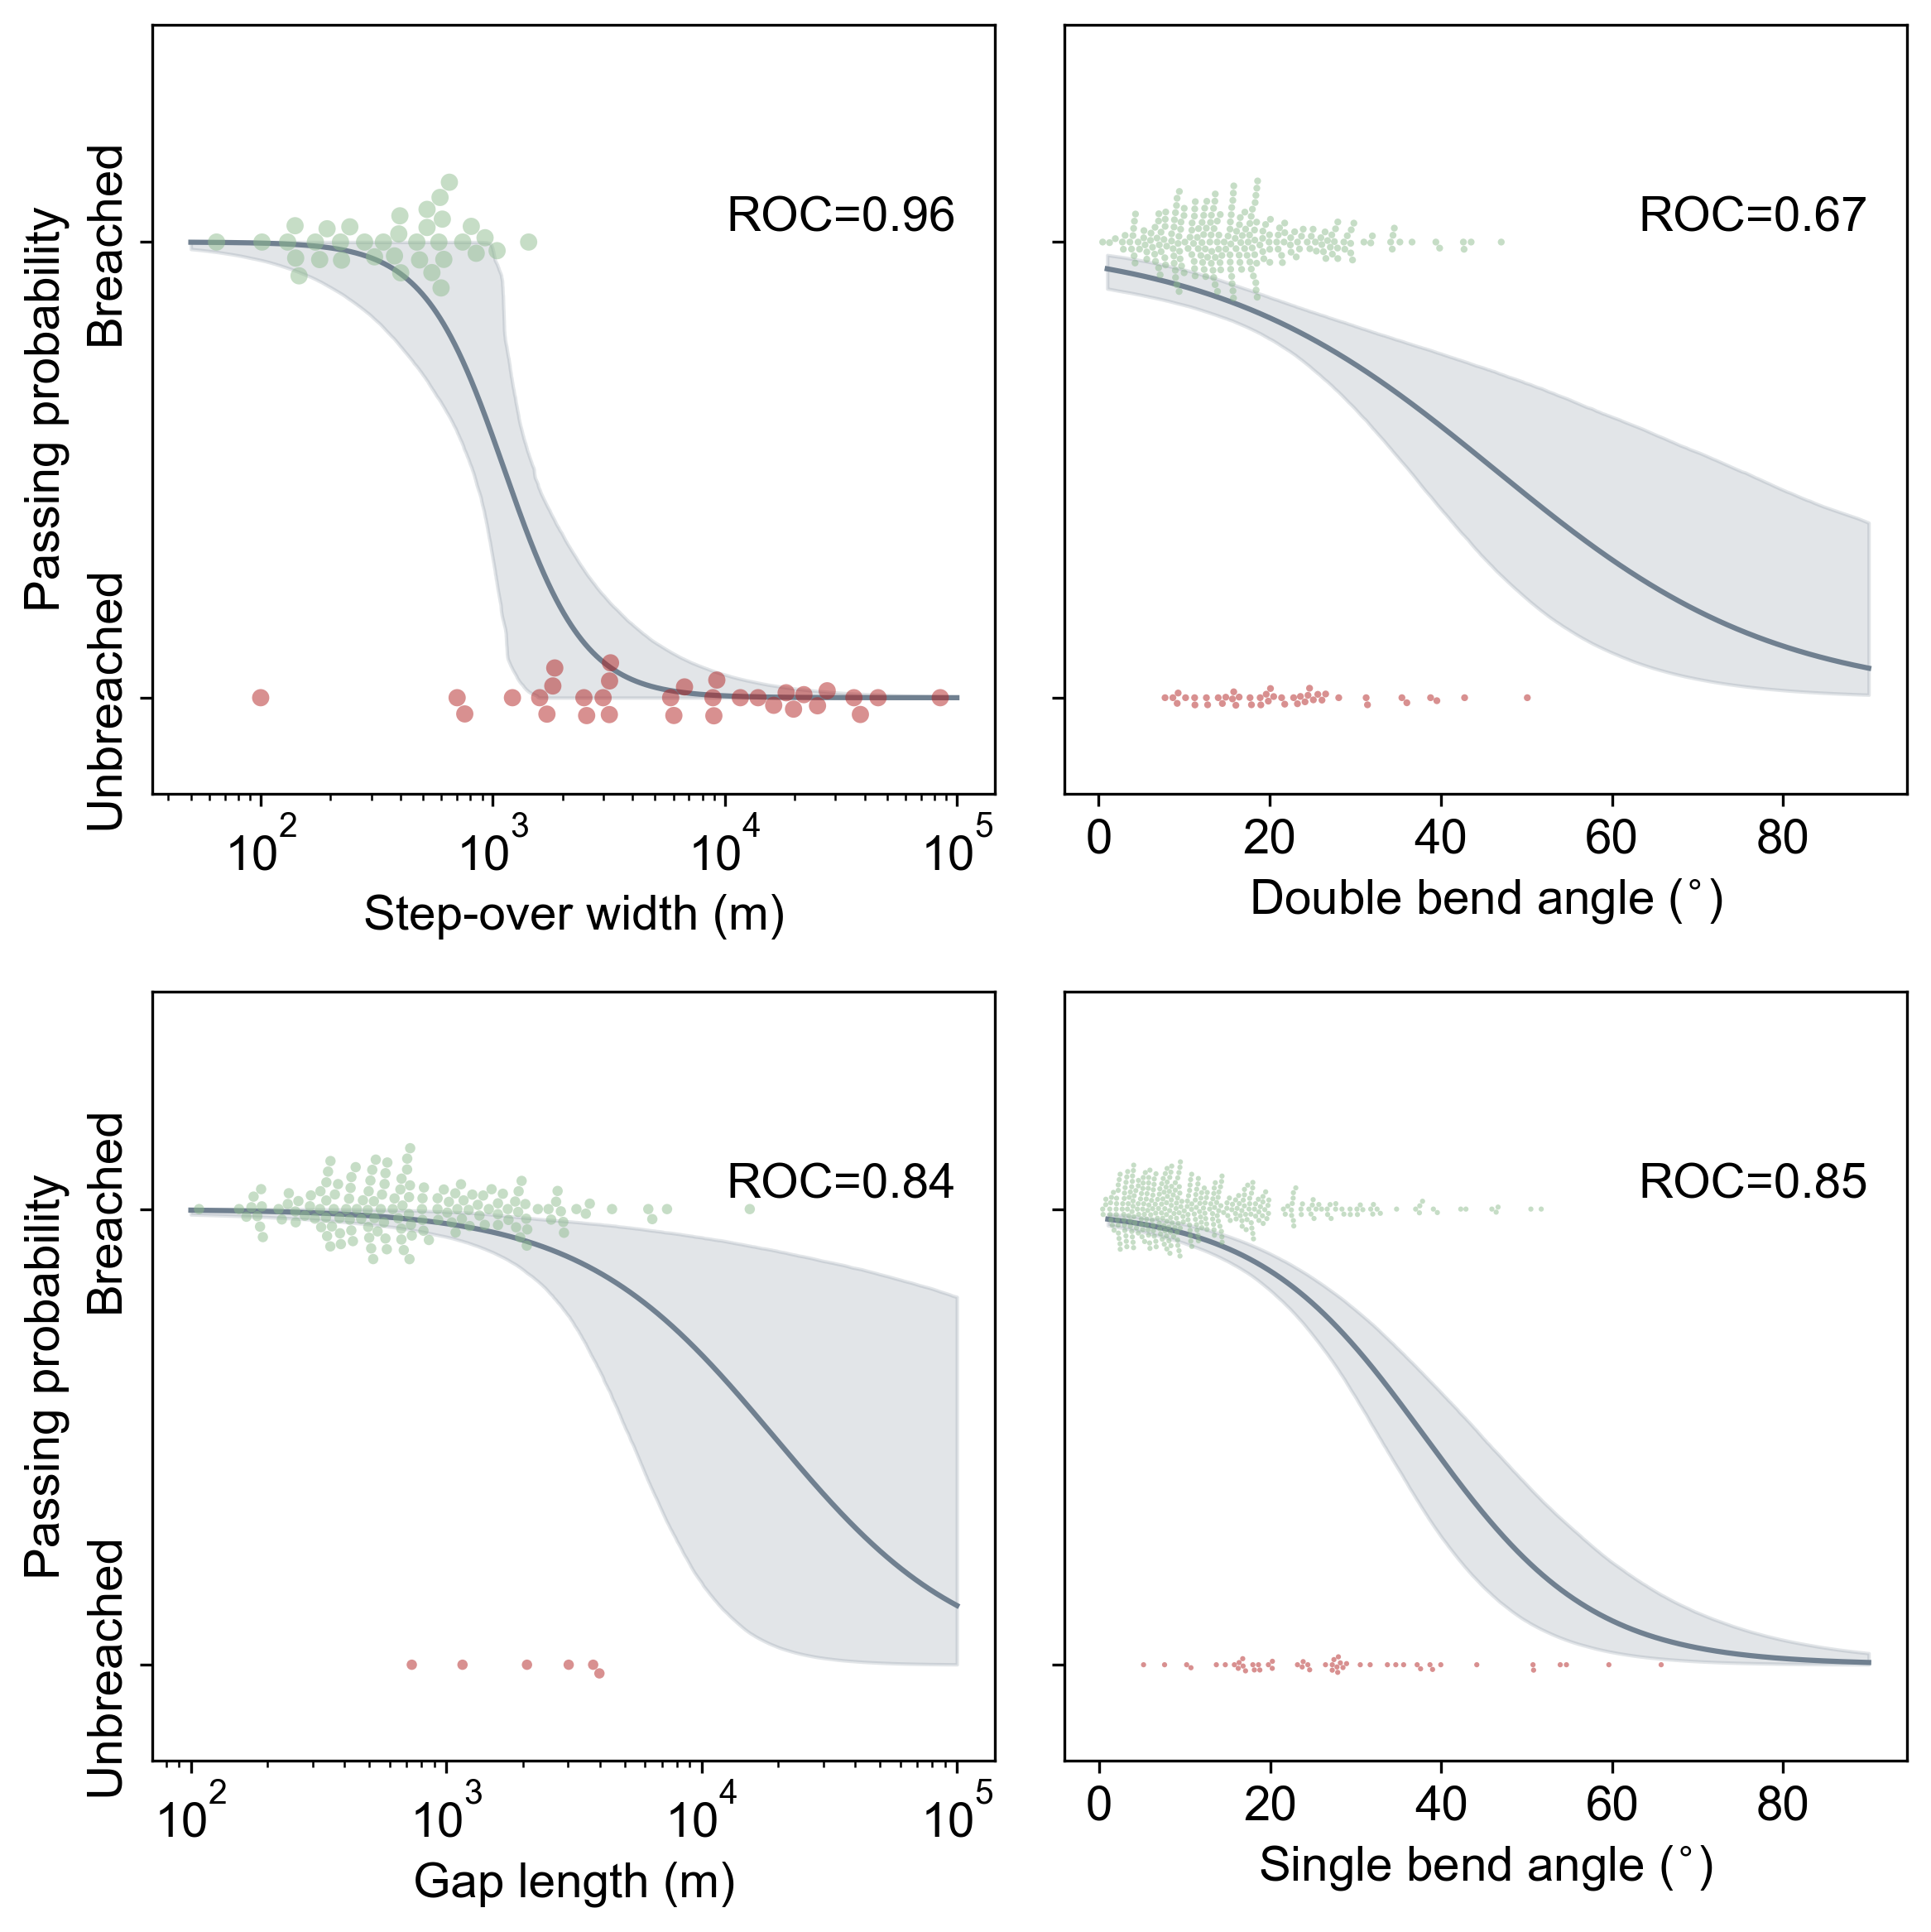

In [161]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey=True, dpi=300)
 
log_stepover, acc_stepover, pre_stepover, f1_stepover, roc_stepover, confusion_matrix_stepover, BUbin_stepover,xstepover = build_logistic_regression(
    'stepover', 
    'none', 
    'length', 
    None, 
    axes[0,0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

log_bend_double, acc_bend_double, pre_bend_double, f1_bend_double, roc_bend_double, confusion_matrix_bend_double,BUbin_bend_double,xbenddouble= build_logistic_regression('bend', 'double', 'angle',None,axes[0,1],1,90,'slategrey','Double bend angle ($^{\circ}$)',2)
log_bend_single, acc_bend_single, pre_bend_single, f1_bend_single, roc_bend_single, confusion_matrix_bend_single,BUbin_bend_single,xbendsingle = build_logistic_regression('bend', 'single', 'angle', None,
                                                                                                                                                                           axes[1,1],1,90,'slategrey','Single bend angle ($^{\circ}$)',1.5)

log_gap, acc_gap, pre_gap, f1_gap, roc_gap, confusion_matrix_gap, BUbin_gap,xgap = build_logistic_regression('gap', 'none', 'length', None, axes[1,0],100,100000,'slategrey','Gap length (m)',3)


plt.tight_layout()
plt.savefig('GRL/PP_EQgates.pdf')
plt.show()

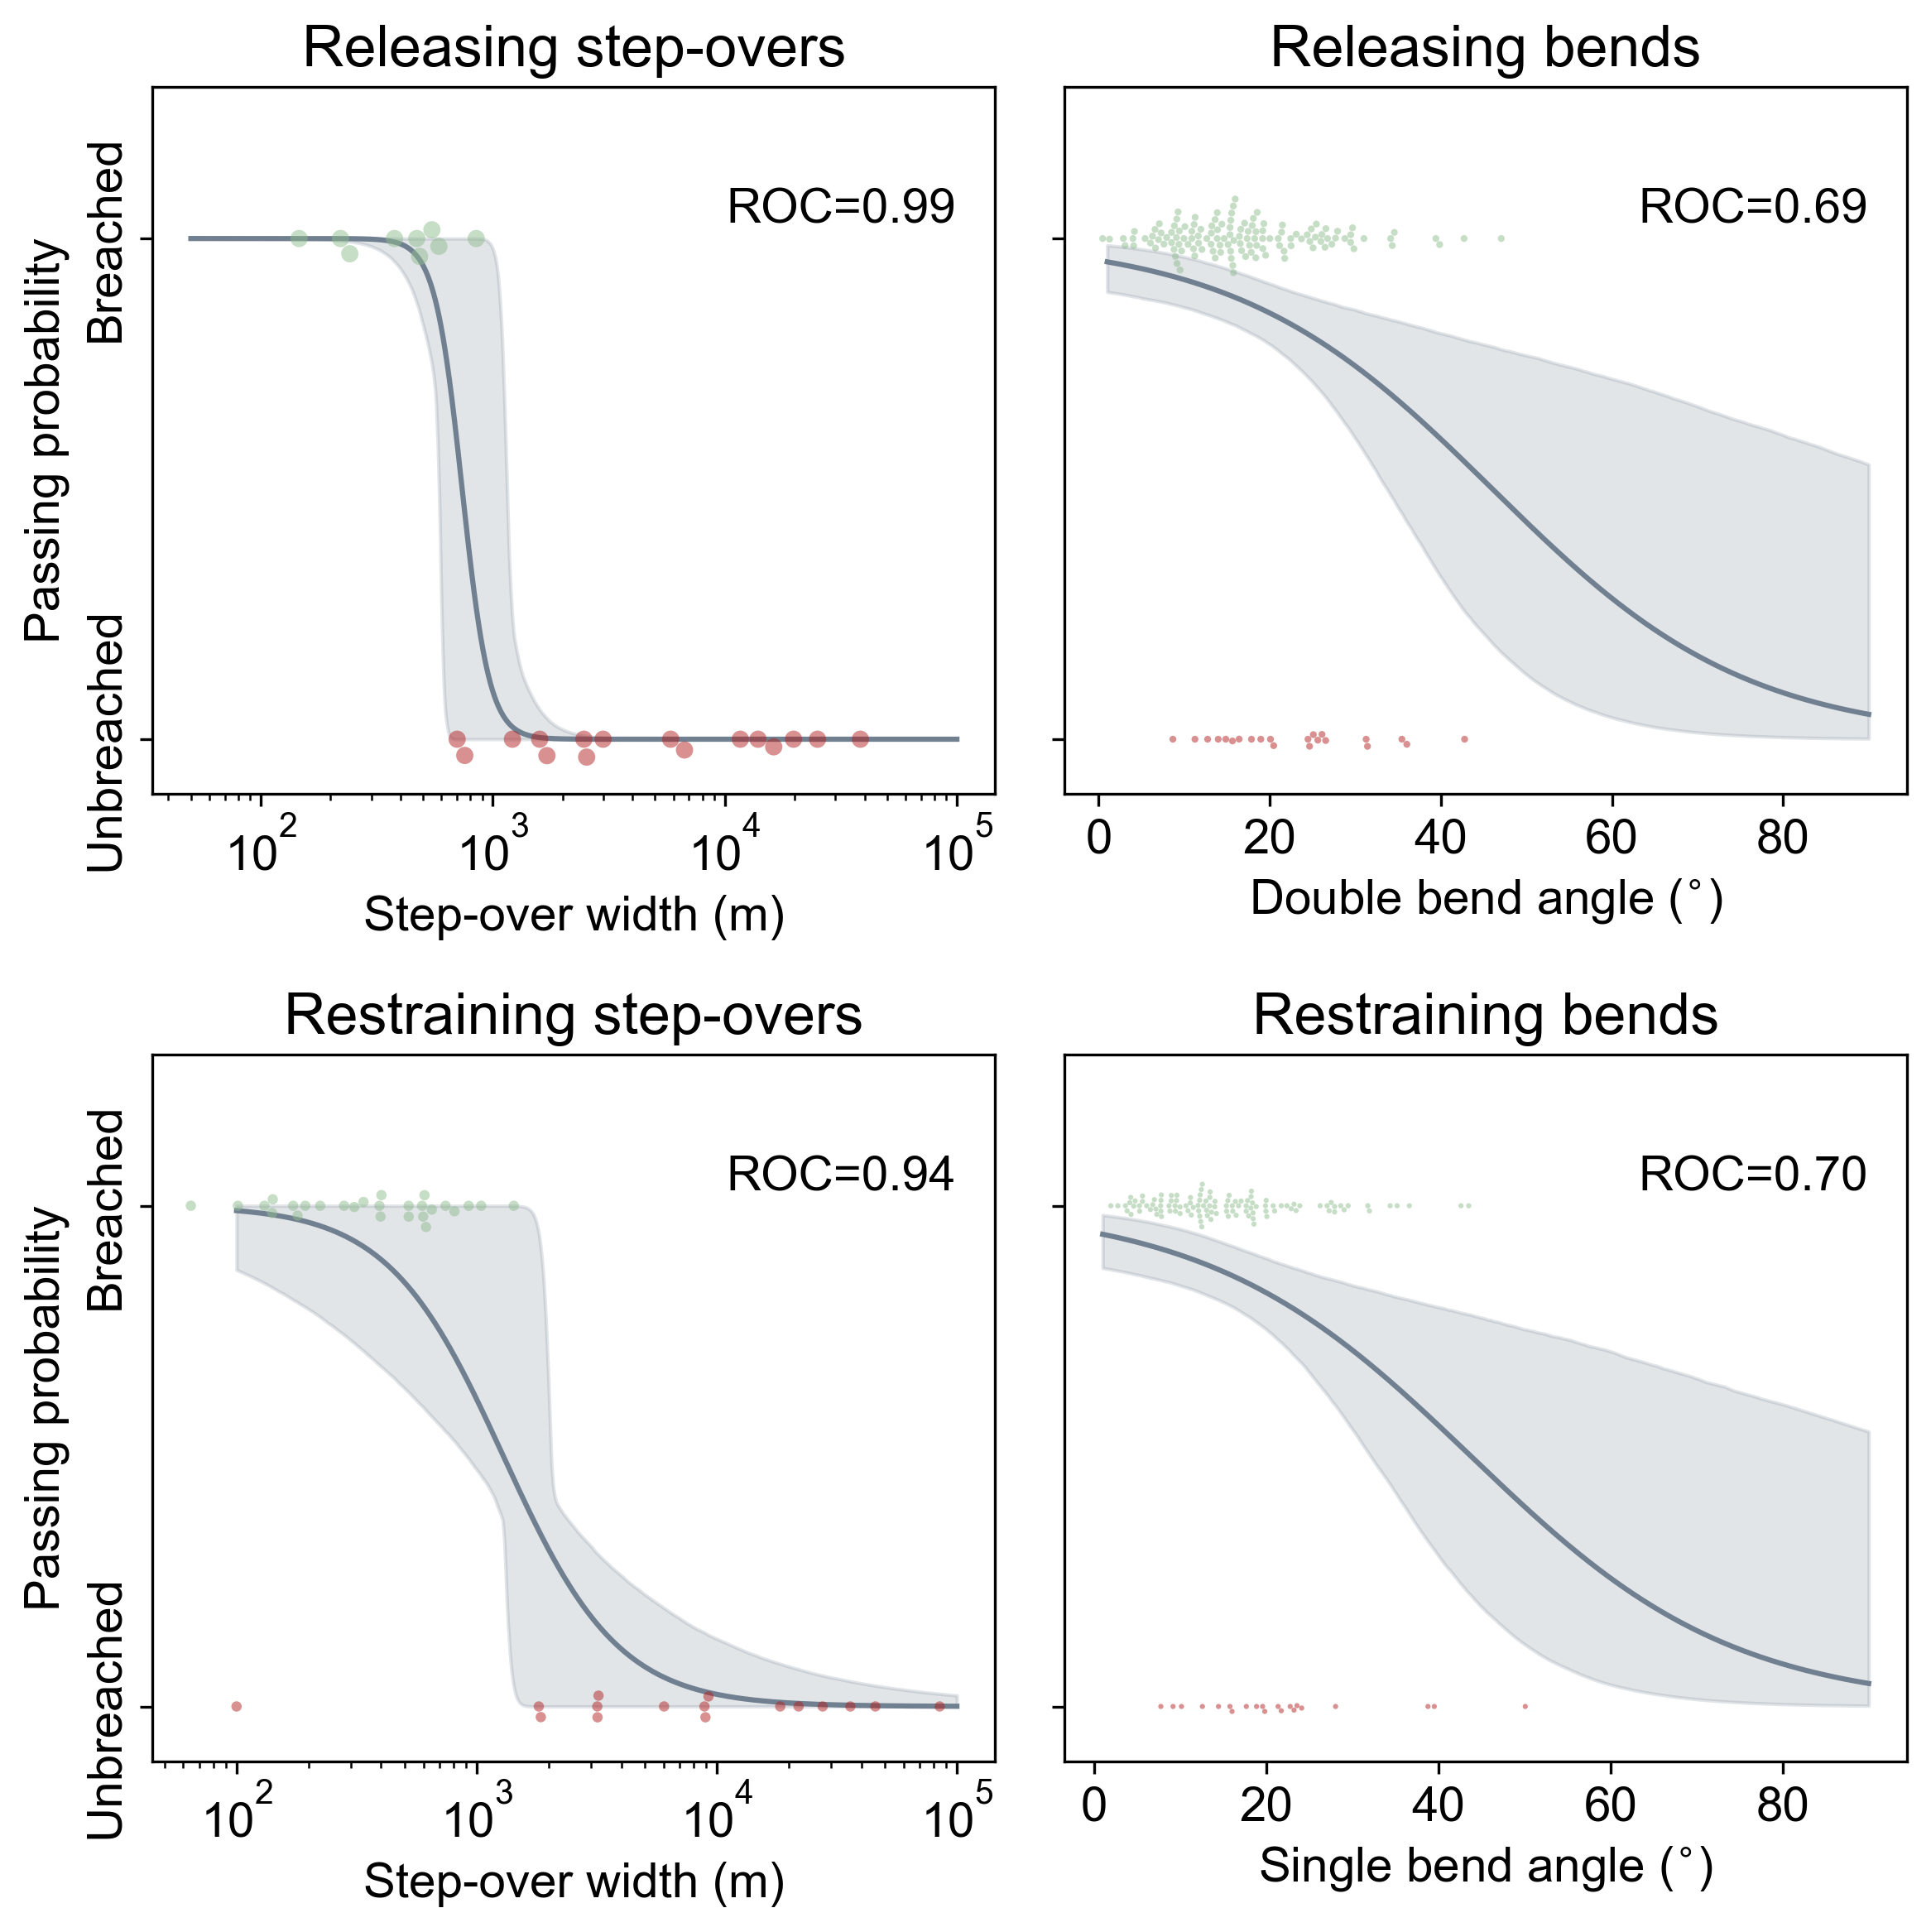

In [162]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey=True, dpi=300)
 
build_logistic_regression(
    'stepover', 
    'releasing', 
    'length', 
    None, 
    axes[0,0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

build_logistic_regression('bend', 'releasing', 'angle', None,
                         axes[0,1],1,90,'slategrey','Double bend angle ($^{\circ}$)',2)
build_logistic_regression('bend', 'restraining', 'angle', None, 
                         axes[1,1],1,90,'slategrey','Single bend angle ($^{\circ}$)',1.5)
build_logistic_regression('stepover', 'restraining', 'length', 'balanced', 
                          axes[1,0],100,100000,'slategrey','Step-over width (m)',3)

axes[0,0].set_title('Releasing step-overs')
axes[0,1].set_title('Releasing bends')
axes[1,1].set_title('Restraining bends')
axes[1,0].set_title('Restraining step-overs')

plt.tight_layout()
plt.savefig('GRL/PP_EQgates_RR_categories.pdf')
plt.show()

Predict probability for earthquake gate of given geometry based on logistic model for that type of earthquake gate

In [163]:
x = np.atleast_2d(46).T
# x = np.atleast_2d(np.log10(19000)).T
proba = log_bend_double.predict_proba(x)[:,0]
proba

array([0.50544287])

Let's assess the quality of the logistic regressions. 

In [164]:
print("ROC step-over",roc_stepover)
print("ROC single bend",roc_bend_single)
print("ROC double bend",roc_bend_double)
print("ROC gap",roc_gap)

ROC step-over 0.9592013888888888
ROC single bend 0.854539641943734
ROC double bend 0.6747723132969035
ROC gap 0.844671201814059


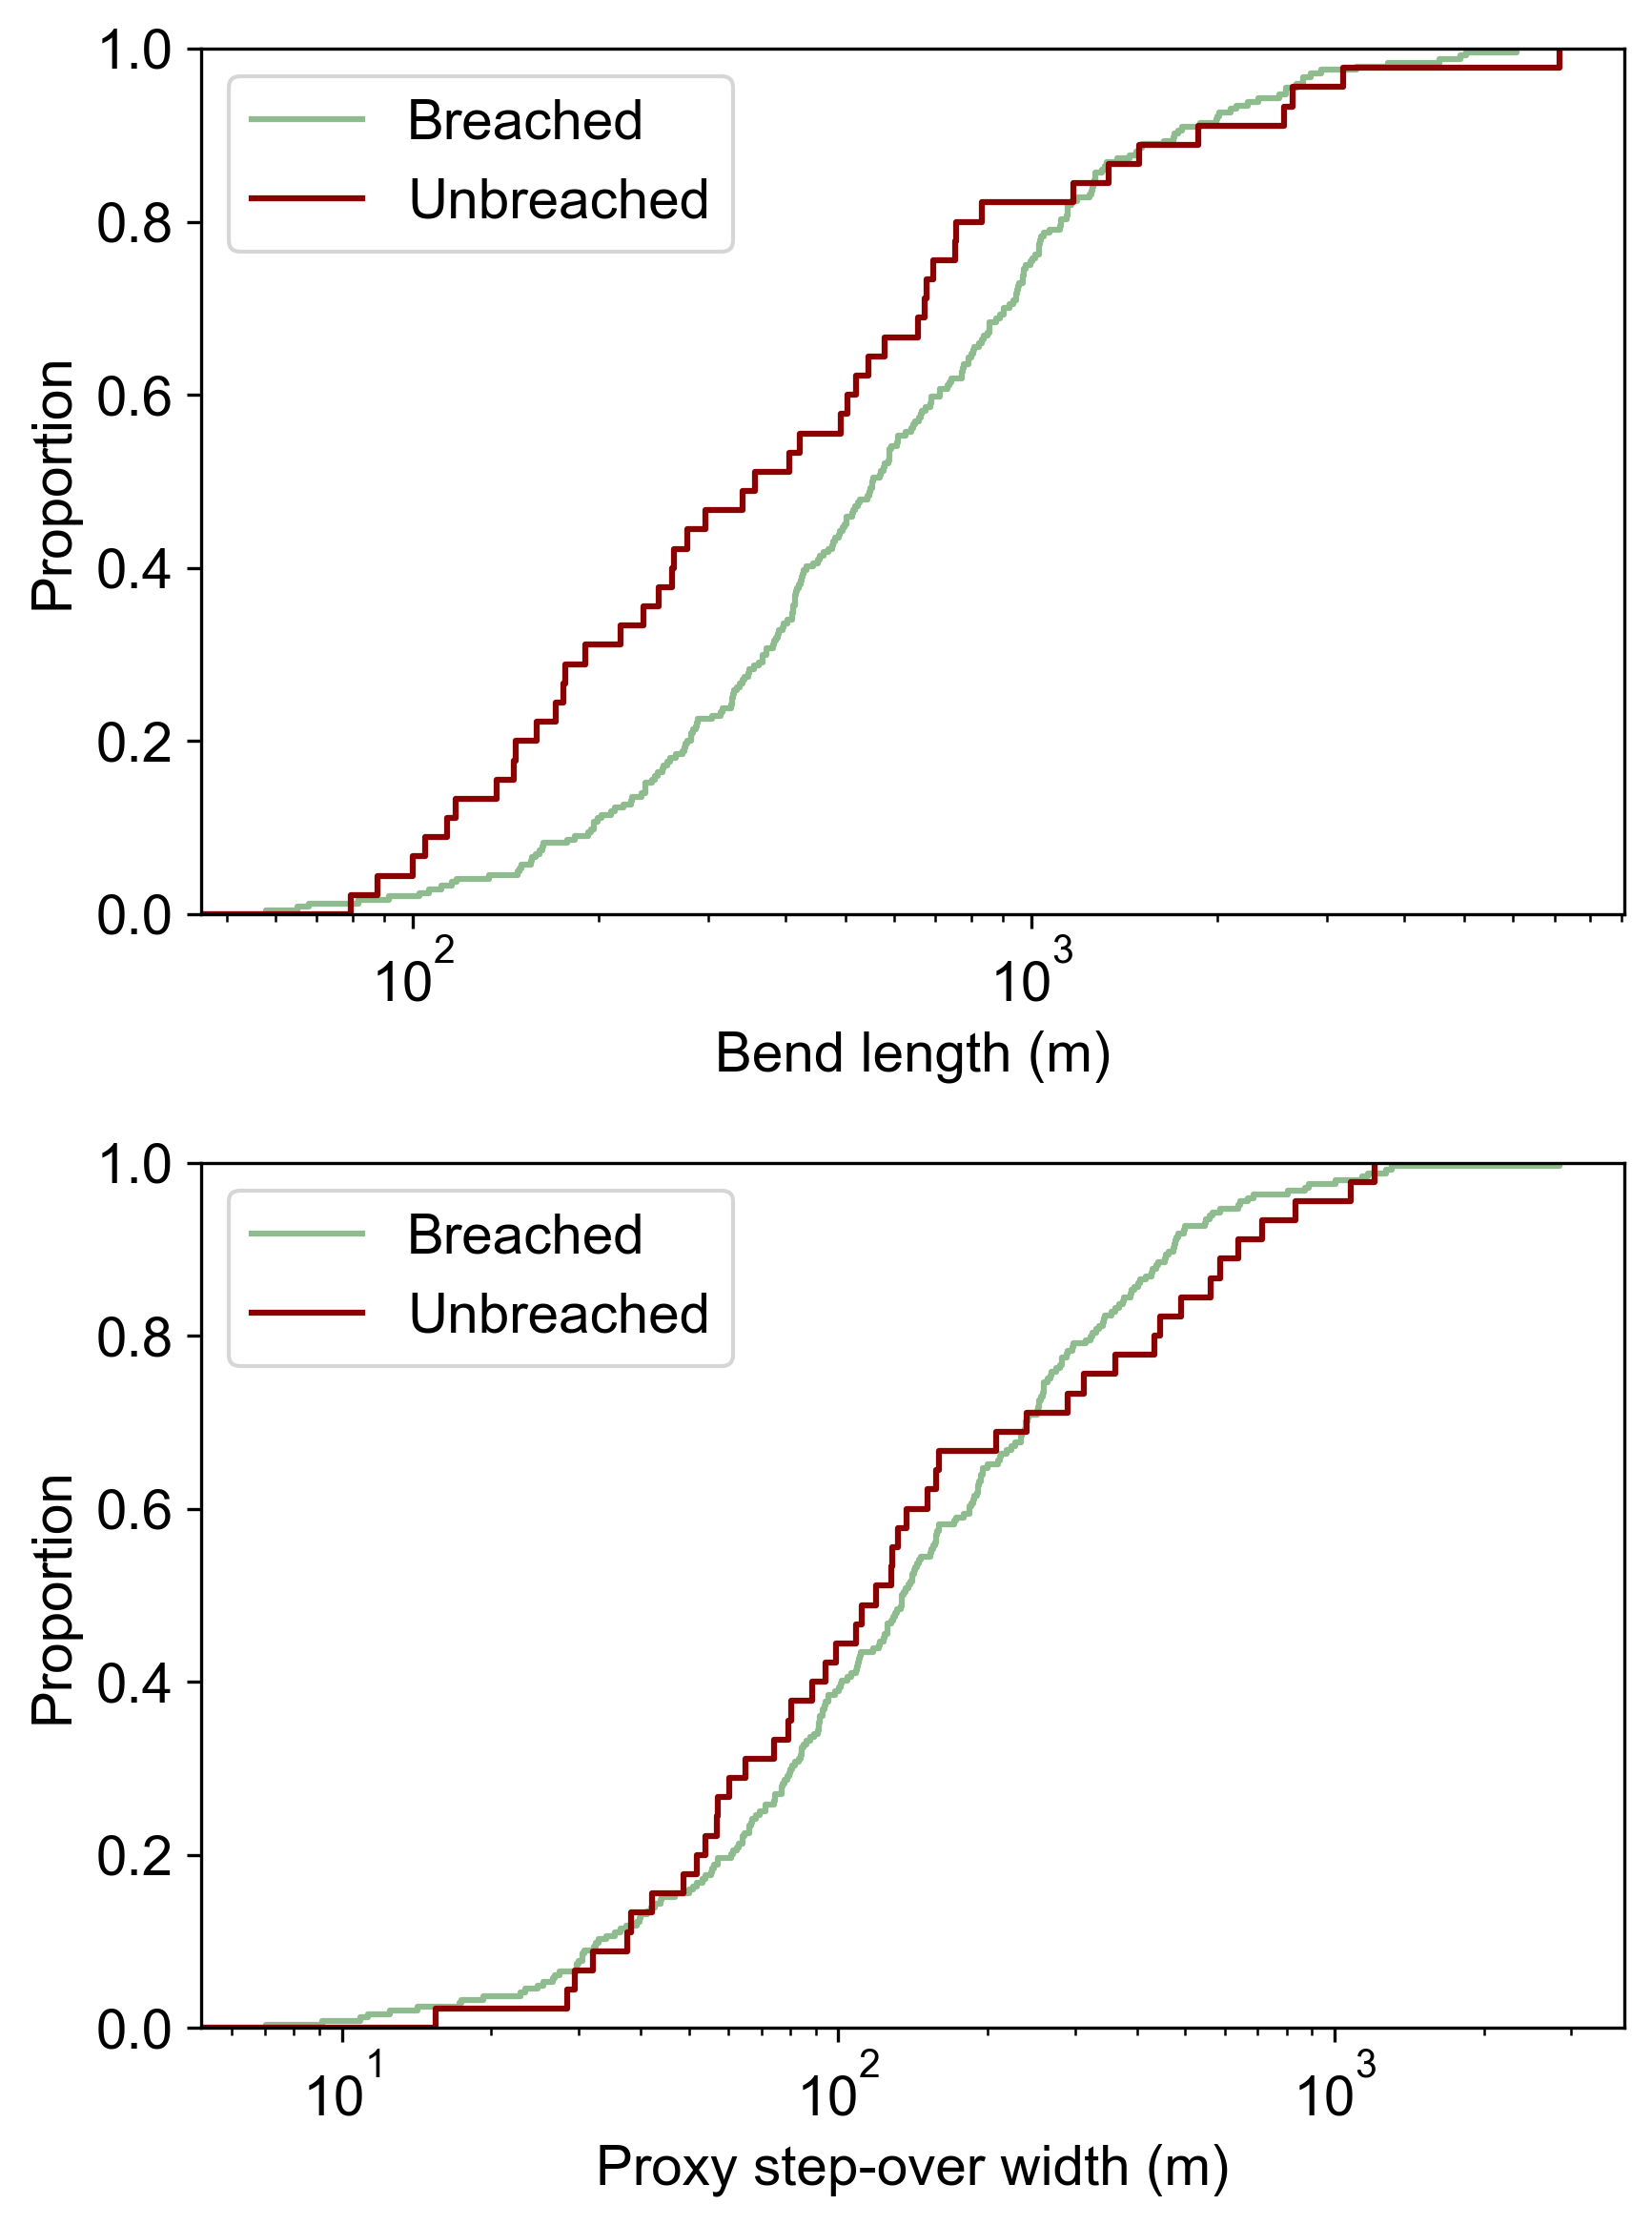

In [165]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_cdf_bend_lengths('bend', 'double', 'Distance splay or double bend (m)', 'darkseagreen','darkred',ax[0],'Bend length (m)','Breached', 'Unbreached')
build_cdf_bend_lengths('bend', 'double', 'Spacing double bend (m)', 'darkseagreen','darkred',ax[1],'Proxy step-over width (m)','Breached', 'Unbreached')
plt.tight_layout()
plt.savefig('GRL/bend_length_CDFs.pdf')

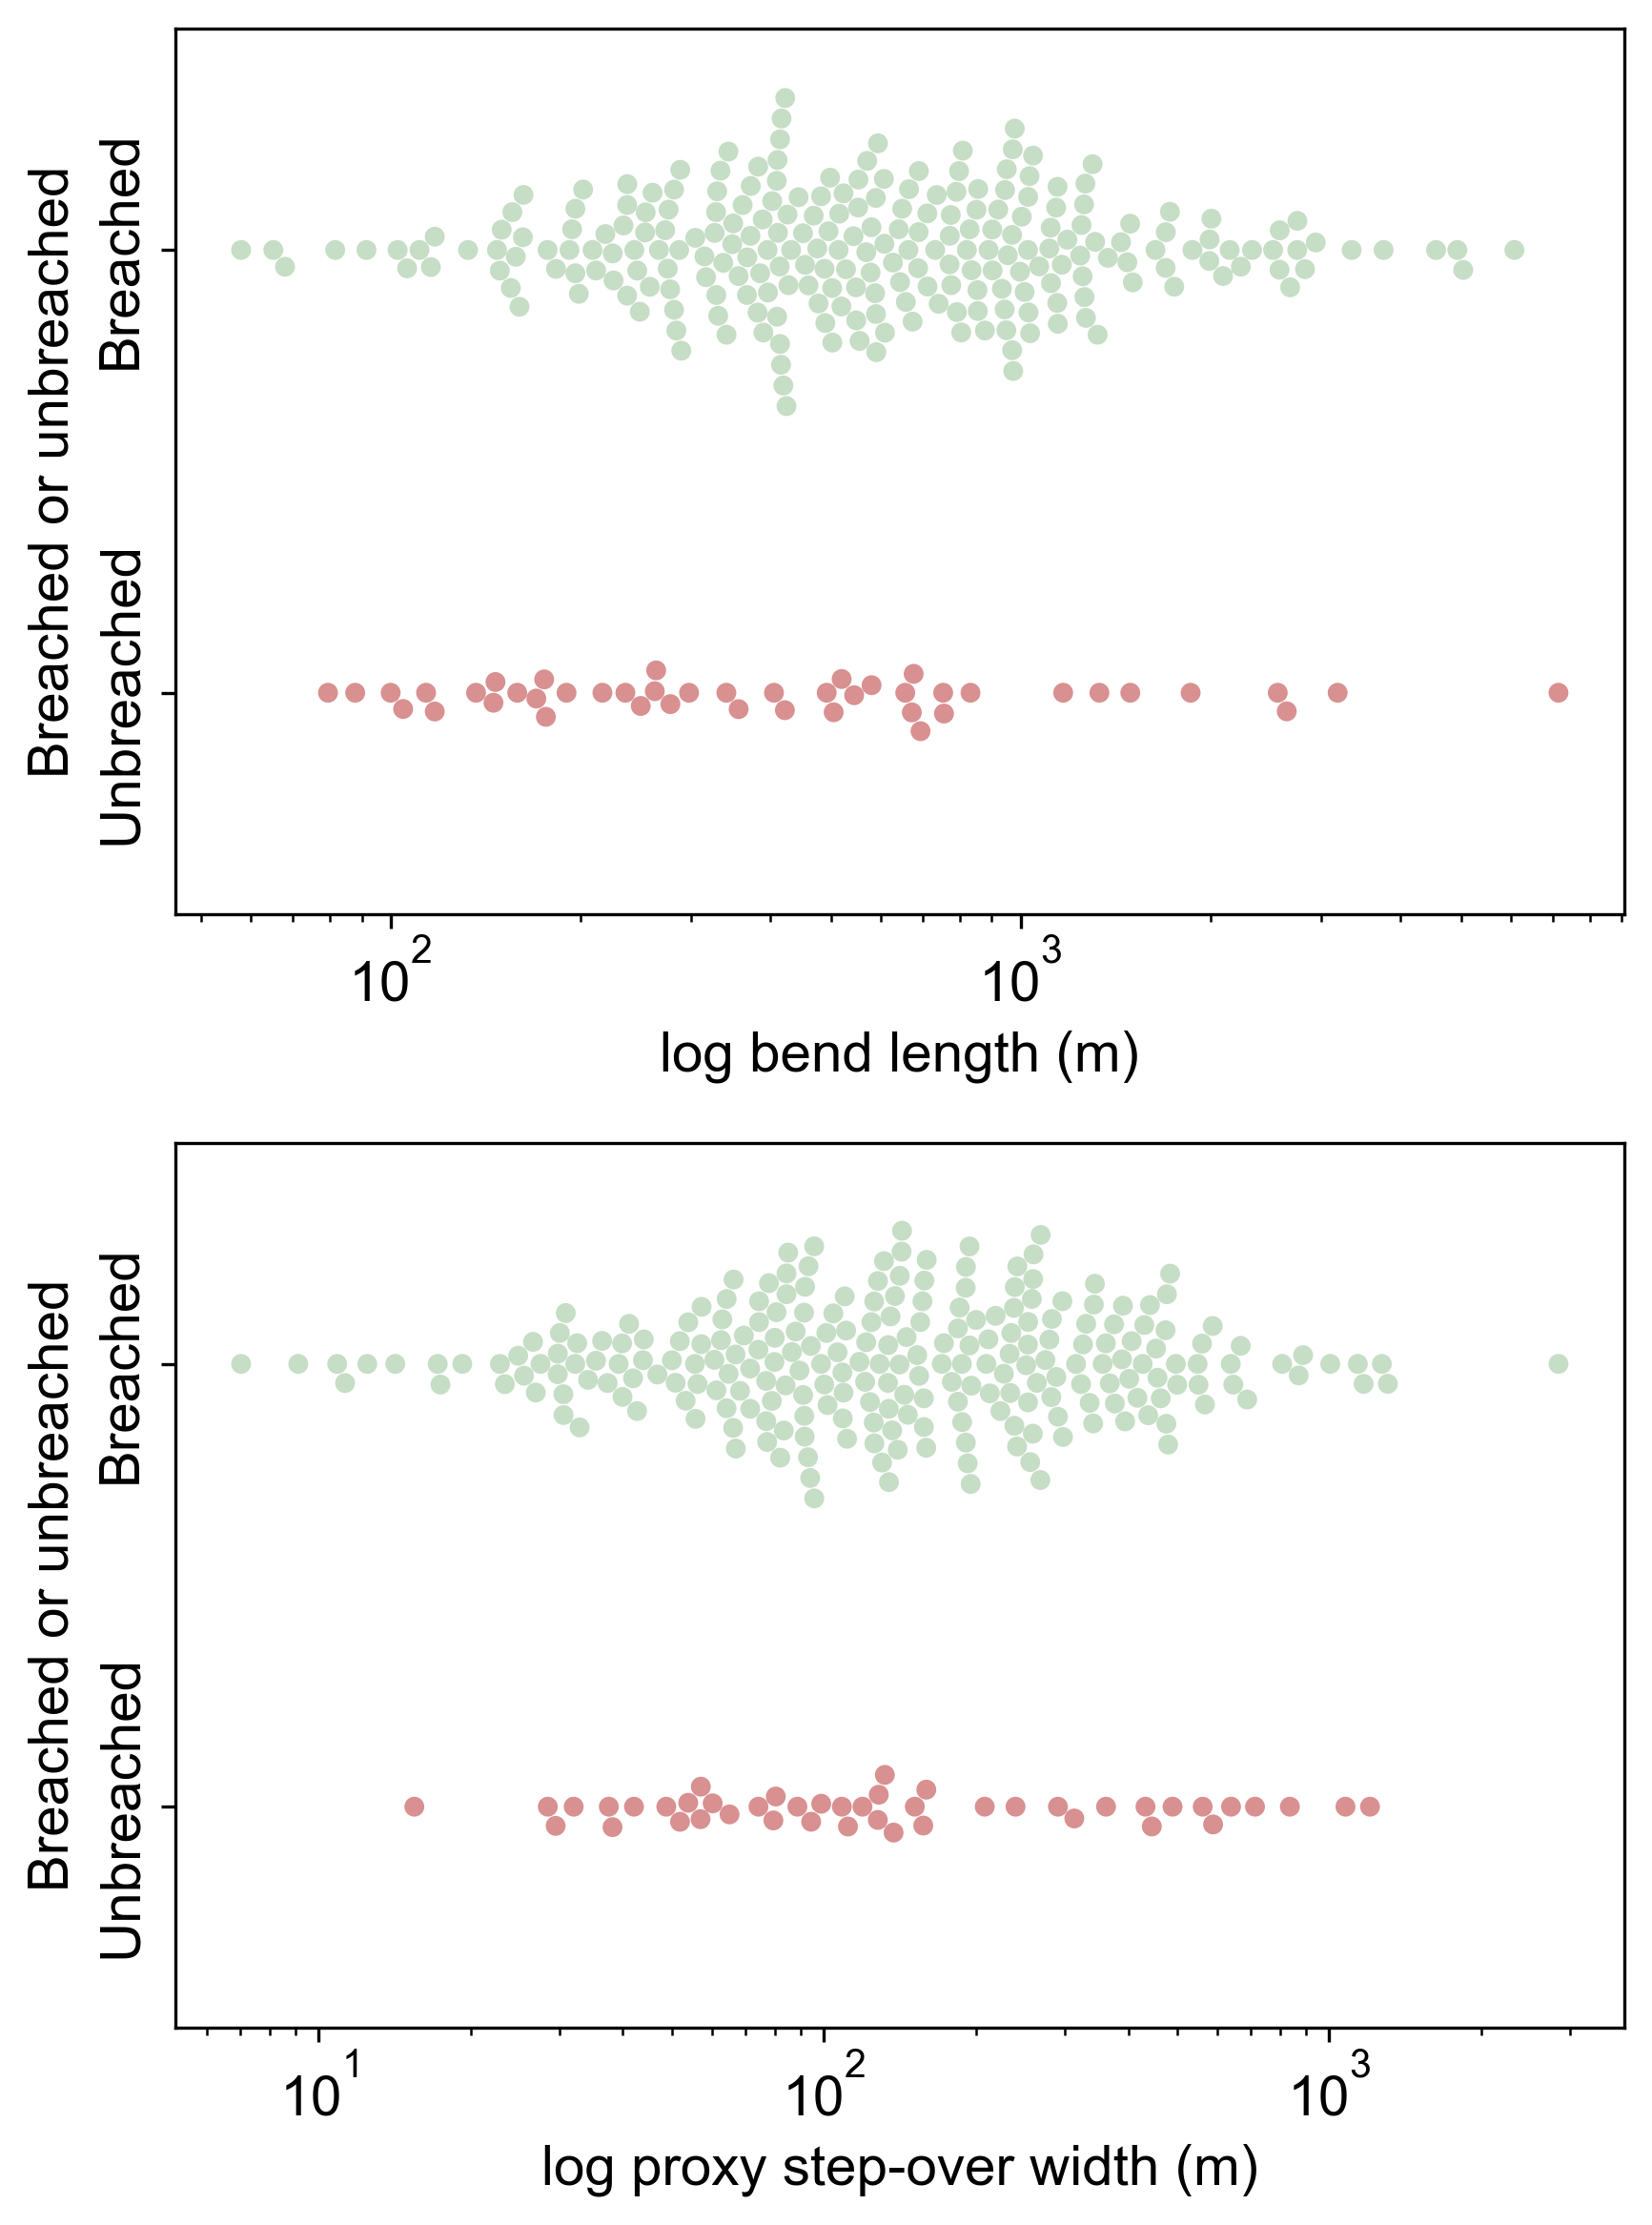

In [166]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_regression_double_bend_length('bend', 'double', 'Distance splay or double bend (m)',ax[0],1,4000,'log bend length (m)',5)
build_regression_double_bend_length('bend', 'double', 'Spacing double bend (m)',ax[1],1,4000,'log proxy step-over width (m)',5)
plt.tight_layout()
plt.savefig('GRL/bend_lengths.pdf.pdf')

Confusion matrices to evaluate logistic model fit

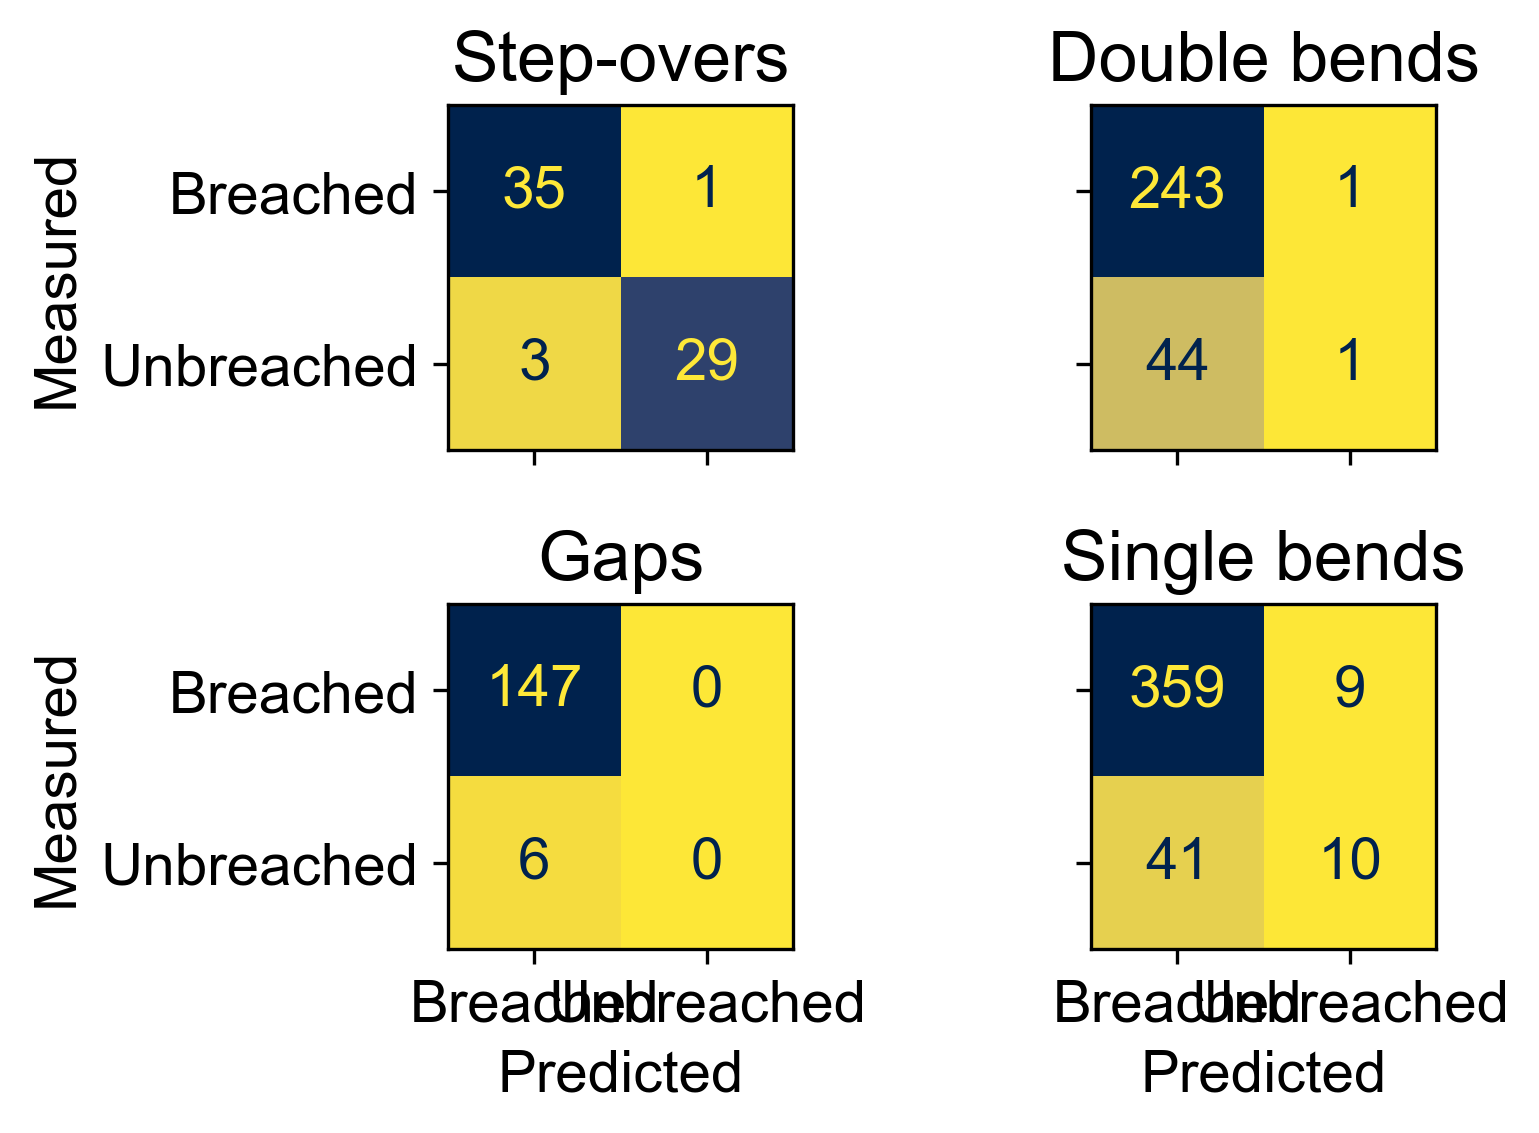

In [167]:
fig, axes = plt.subplots(2,2,figsize=(6,4), dpi=300,sharex=True,sharey=True)

# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('cividis')
labels = ['Breached', 'Unbreached']
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

disp_stepover = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_stepover,display_labels=labels)
disp_stepover.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,0])
axes[0,0].set_title('Step-overs')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Measured')

disp_double_bend = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_double,display_labels=labels)
disp_double_bend.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,1])
axes[0,1].set_title('Double bends')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')

disp_double_single = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_single,display_labels=labels)
disp_double_single.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,1])
axes[1,1].set_title('Single bends')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('')

disp_gap = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_gap,display_labels=labels)
disp_gap.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,0])
axes[1,0].set_title('Gaps')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Measured')

plt.tight_layout()
plt.savefig('GRL/confusion_matrices.pdf')
plt.show()


ks tests:

In [168]:
# ks test for determining whether populations are different (statistically)
mpl.rcParams['font.size'] = 14
double_bend_ks = kstest_variables('bend', 'single', 'angle')
print(double_bend_ks)
splay_ks = kstest_variables('splay', 'none', 'angle')
print(splay_ks)

KstestResult(statistic=0.6084825234441603, pvalue=2.987200172137618e-16, statistic_location=14.5420634348074, statistic_sign=1)
KstestResult(statistic=0.32666666666666666, pvalue=0.06517251106377434, statistic_location=25.8837228358785, statistic_sign=-1)


Nearest distance between strand and step-over:

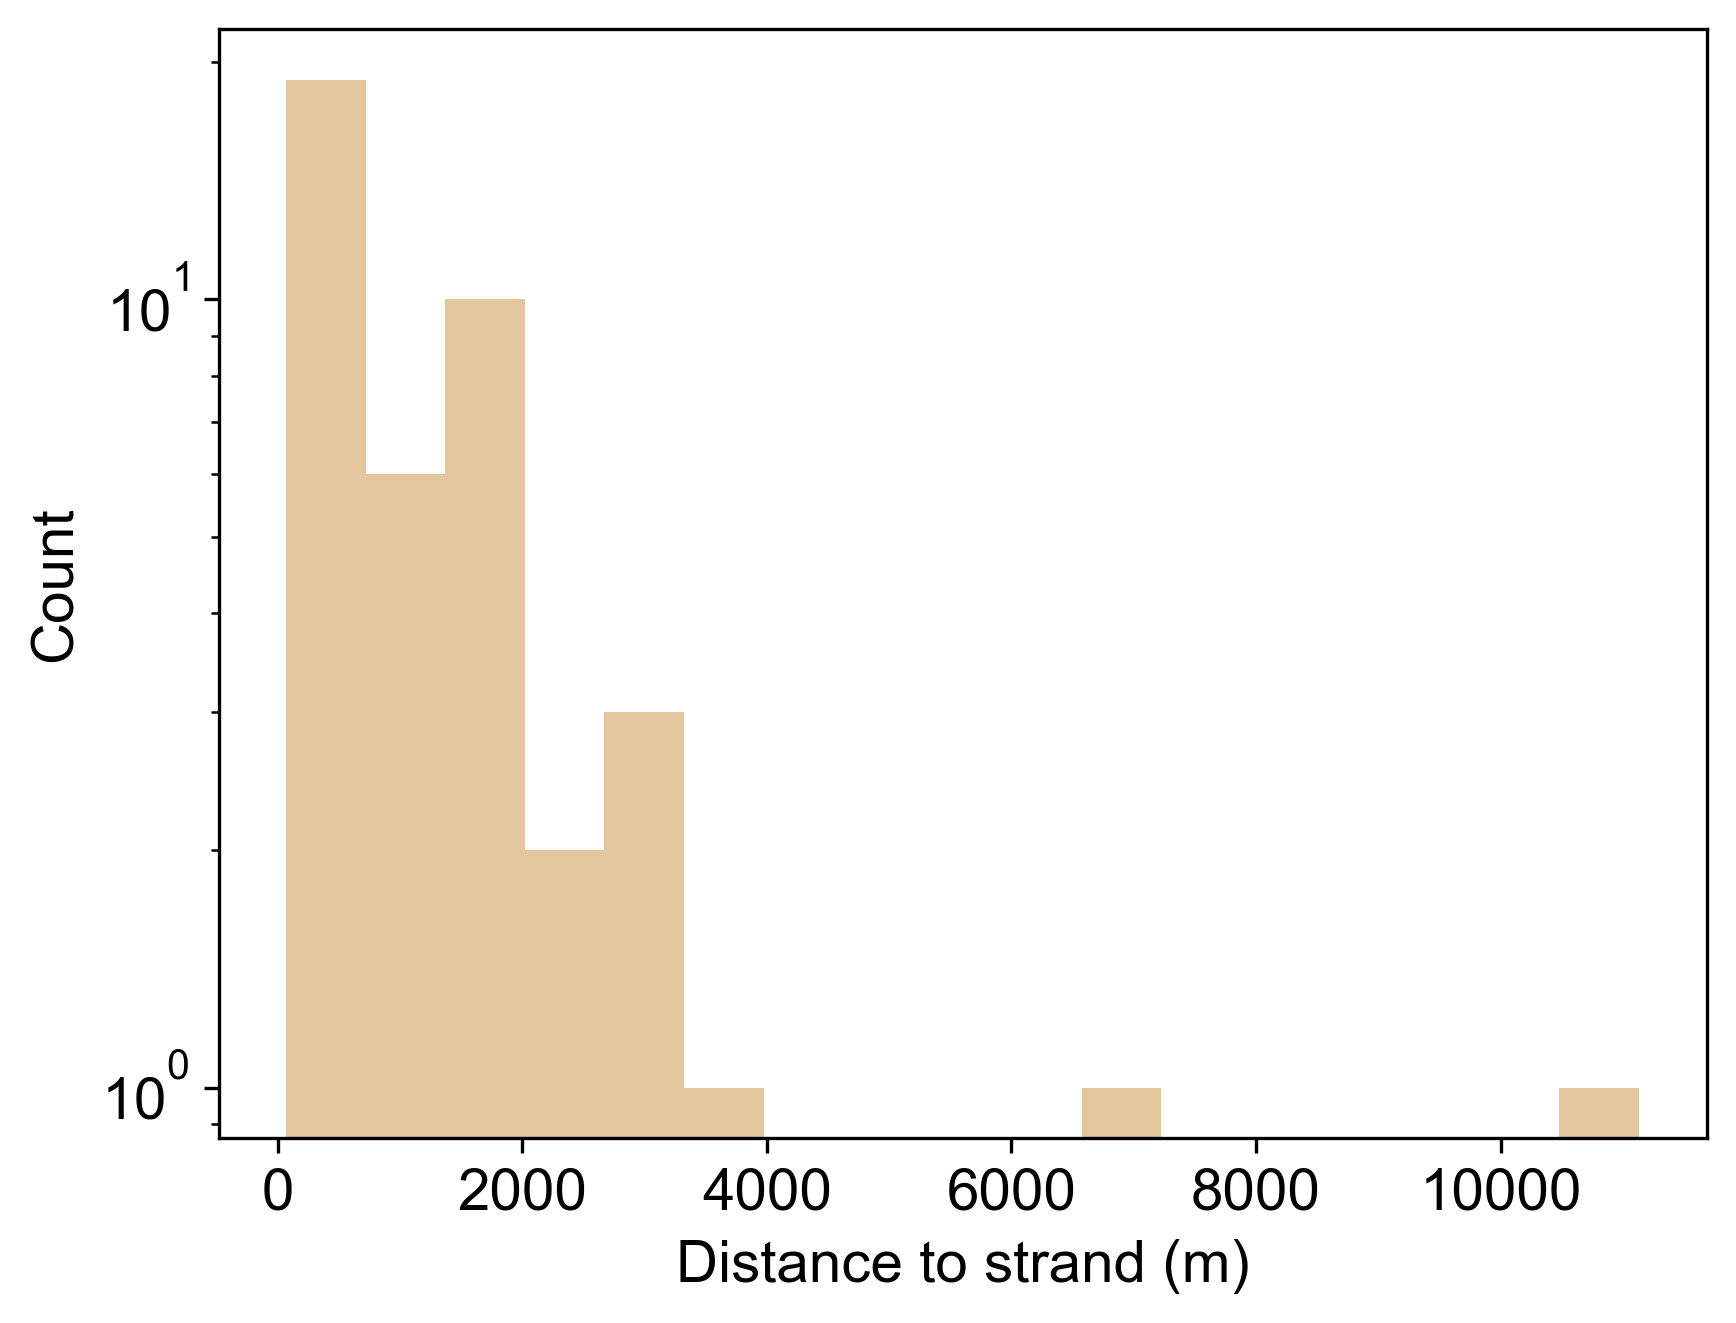

In [169]:
strand = grouped.get_group("strand")

bins = np.histogram_bin_edges(strand, bins=5, range=[1,max(strand['Length (m) or angle (deg)'])], weights=None)

sns.histplot(strand,x='Length (m) or angle (deg)',color='burlywood',edgecolor='none',alpha=0.8,label='Strand')
plt.yscale('log')
plt.xlabel('Distance to strand (m)')
plt.savefig('GRL/strand_RR.pdf')
plt.show() 

# Analysis of earthquake likelihood magnitude dependence

Extract passing probability for all mapped gates based on logistic models:
-- Note gaps, splays (statiscally indifferent), and strands are all assigned probabilities of 1 given the do not influence rupture propagation

In [170]:
fun_dict = {
    'log_stepover' : log_stepover,  
    'log_bend_single': log_bend_single,
    'log_bend_double':log_bend_double,
    'log_gap': log_gap
}

PR = []

for i in range(len(data)): 
    datai = data.iloc[i]
    featurei = datai['Feature']
    RRi = datai['Type (releasing or restraining)']

    if featurei == 'bend':
        RRi = datai['Type (releasing or restraining)']
        RRstr = str(RRi)

        if RRstr == 'nan':
            name_select = 'log' + '_' + 'bend' + '_' + 'single'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

        else:
            name_select = 'log' + '_' + 'bend' + '_' + 'double'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

    # elif featurei == 'gap':
    #     strlog = 'log'
    #     name_select = strlog + '_' + 'gap' 
    #     extract = fun_dict[name_select]
    #     x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
    #     PRi  = extract.predict_proba(np.log10(x))[:,0]

    elif featurei == 'stepover': 
        featurestr = str(featurei)
        strlog = 'log'
        RRstr = str(RRi)
        name_select = strlog + '_' + featurestr 
        extract = fun_dict[name_select]
        x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
        PRi  = extract.predict_proba(np.log10(x))[:,0]
    
    else:
        PRi = 1
        

    PR.append(PRi)

data['PR'] = PR


Calculate earthquake likelihood for each event based on the previously estimated probabilities for each earthquake gate

In [171]:
event = data["Earthquake"]
event.unique()

mag = np.array([])
event_likelihood = np.array([])
event_group = event.unique()
cumdisp = np.array([])
SRL = np.array([])

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    mag_i = subsetb['Magnitude']
    mag_i = mag_i.iloc[0]
    cum_disp_i = subsetb['Cumulative displacement']
    cum_disp_i = cum_disp_i.iloc[0]
    SRLi = subsetb['Total rupture length']
    SRLi = SRLi.iloc[0]

    subsetb['PR'] = subsetb['PR'].astype(float)
    subsetb['PRlog'] = np.log10(subsetb['PR'])   
    event_likelihood_i = np.sum(subsetb['PRlog'])

    print(mag_i,EQ,event_likelihood_i)

    event_likelihood = np.append(event_likelihood, event_likelihood_i)
    mag = np.append(mag,mag_i)
    SRL = np.append(SRL,SRLi)
    cumdisp = np.append(cumdisp,cum_disp_i)

7.7 Balochistan -4.254180093911334
6.63 Borrego -1.2090513247157362
6.19 ChalfantValley -0.10597032681717108
7.0 Darfield -1.2053972182276111
7.9 Denali -2.8674244310820303
7.14 Duzce -2.2356853019957077
6.22 ElmoreRanch -0.5804912718962764
5.2 GalwayLake -0.21796095513642533
7.13 HectorMine -2.297433242880986
6.4 Hualien -0.4080589937539936
6.95 Imperial1940 -0.6918420000254858
6.53 Imperial1979 -1.7613389485841937
7.51 Izmit_Kocaeli -1.9661153938776734
6.6 IzuOshima -0.17559689863006622
6.5 IzuPeninsula -0.18465370238248446
6.9 Kobe -1.0041791954056731
7.0 Kumamoto -1.2785586463247967
7.28 Landers -3.134093943344677
7.7 Luzon -3.4138466756541437
6.0 Napa -0.7385148983520742
7.0 Neftegorsk -0.5021517487775708
6.19 Parkfield1966 -0.7902851849900757
6.0 Parkfield2004 -0.4939919278009178
5.0 Pisayambo -0.2666338531097411
6.4 Ridgecrest1 -1.2810641385320387
7.1 Ridgecrest2 -1.2242961080885713
6.8 SanMiguel -0.5916881508100851
6.54 SuperstitionHills -0.8485383051496239
6.9 Yushu -0.5048549

In [172]:
# probability of stopping on straight segment 
n_ends_no_gates = 13
total_SRL = np.sum(SRL)
p_straight = n_ends_no_gates/total_SRL
p_continue_straight = 1-p_straight

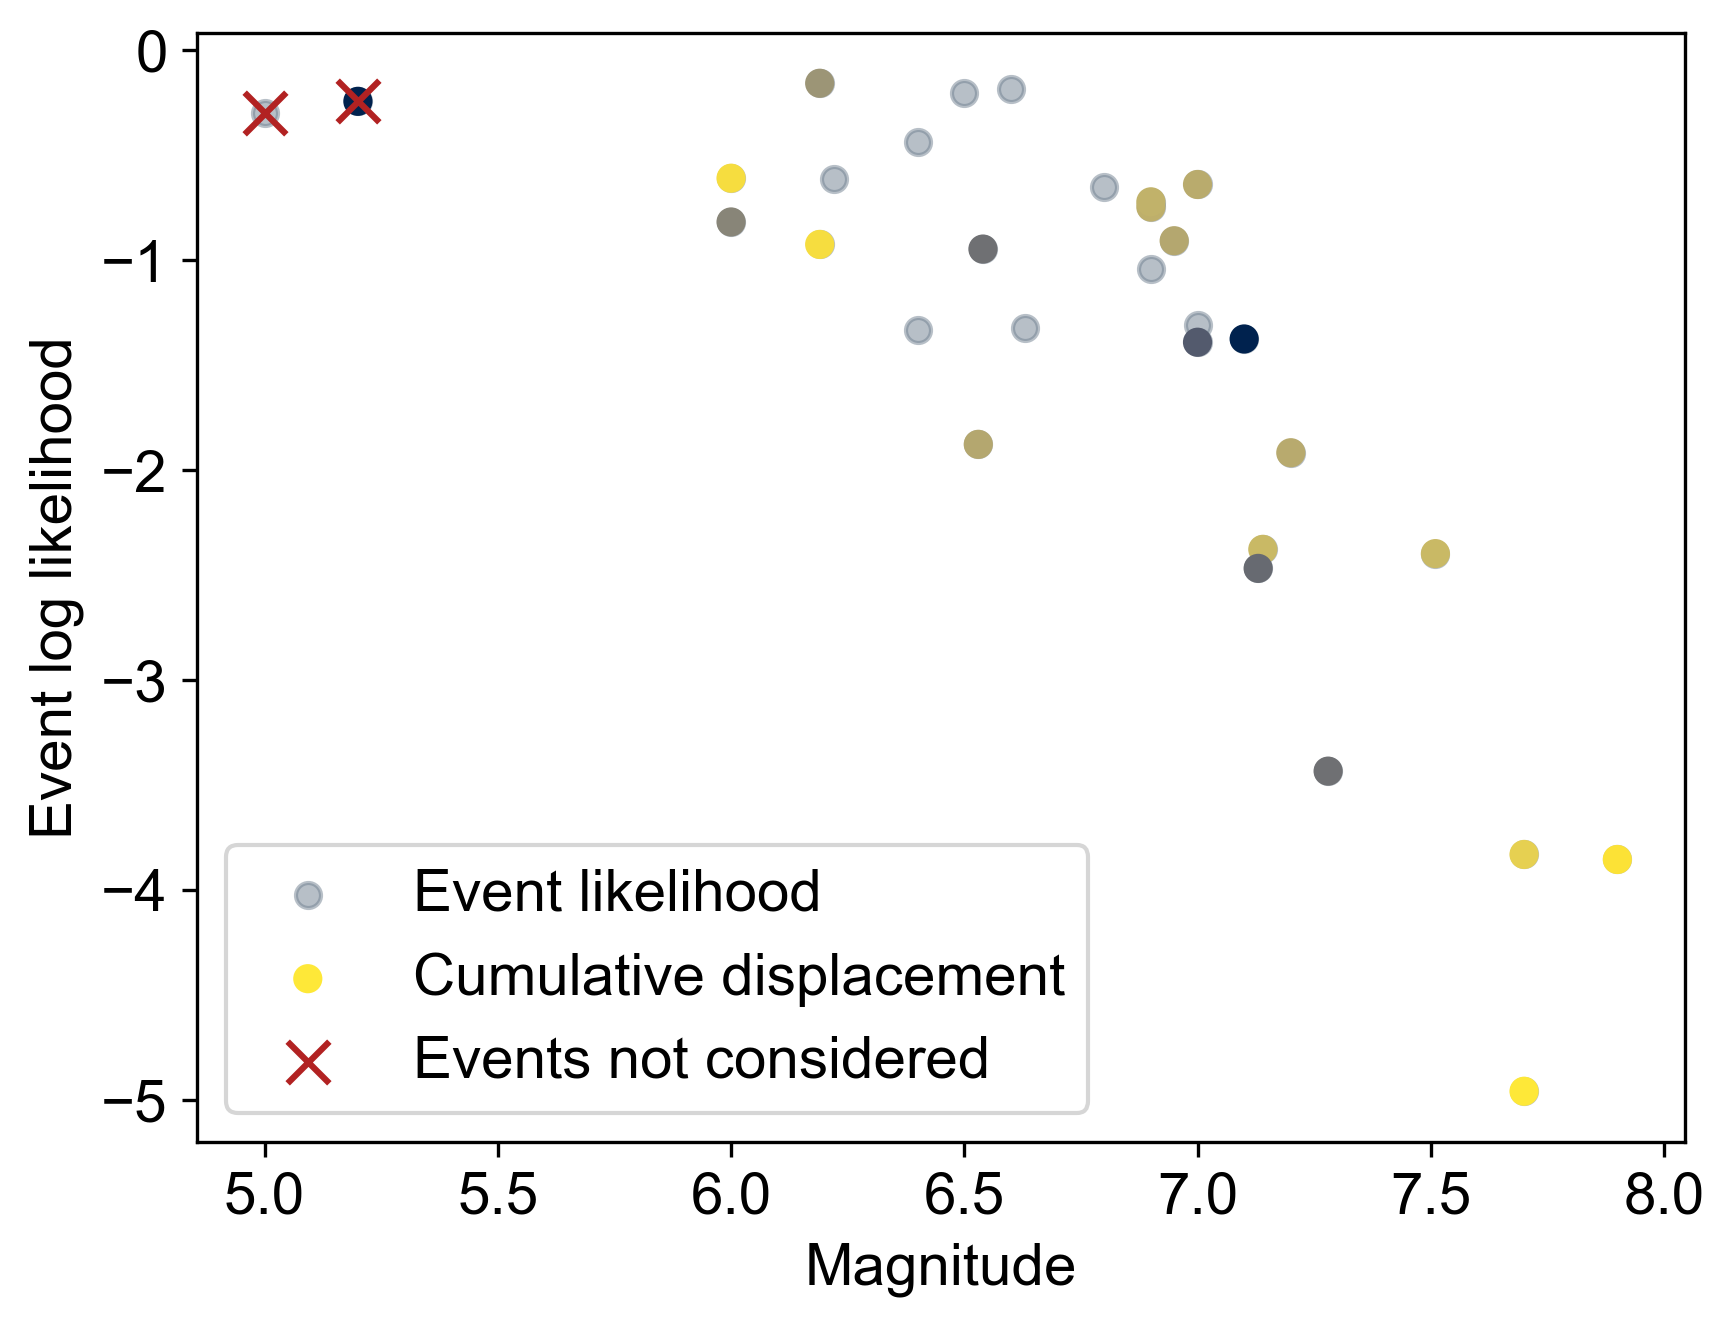

In [173]:
plt.figure()
plt.scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c='slategrey',alpha=0.5,label='Event likelihood')#,edgecolors='slategrey')

# for i in range(len(event_group)):
#     plt.annotate(event_group[i], (mag[i], event_likelihood[i]+np.log10(p_continue_straight)*SRL[i]),fontsize=8)

plt.scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c=cumdisp,cmap='cividis',label='Cumulative displacement',norm=mcolors.LogNorm())
#plt.colorbar()

idx = np.where(mag < 6) # remove outliers, will work on map consistency later
plt.scatter(mag[idx],event_likelihood[idx]+np.log10(p_continue_straight)*SRL[idx],c='firebrick',marker='x',s=100,label='Events not considered')
mag_del = np.delete(mag, idx)
cumdisp = np.delete(cumdisp,idx)
event_likelihood_del = np.delete(event_likelihood, idx)
SRL_del = np.delete(SRL, idx)
all_info = stats.linregress(mag_del, event_likelihood_del+np.log10(p_continue_straight)*SRL_del)

##### fit data with linear regression in semilog space (pwl bc mag is logged already)
slope, intercept, r_value, p_value, std_err = stats.linregress(mag_del, event_likelihood_del+np.log10(p_continue_straight)*SRL_del)

# Define the x range for the line plot
x_range = np.linspace(min(mag_del), max(mag_del), 100)

# Calculate the y values for the line plot
y_range = slope * x_range + intercept

# Plot the data and the line fit with error bars
ax[0].plot(x_range, y_range, label=r"$P_{EQ} = %.2f \pm %.2f L^{%.2f \pm  %.2f}$" % (intercept,all_info.intercept_stderr,slope,all_info.stderr),linestyle=':',c='darkorange')

#plt.ylim([-5.5, 0.9])
plt.ylabel('Event log likelihood')
plt.xlabel('Magnitude')
plt.legend()
plt.savefig('GRL/mag_likelihood_displacement.pdf')

-1.9249237297424002 11.665278316111937 1.936439078538338
a = -1.925 +/- 0.282
b = 11.665 +/- 1.936
a = 7.805 +/- 1.453
b = -2.061 +/- 0.320


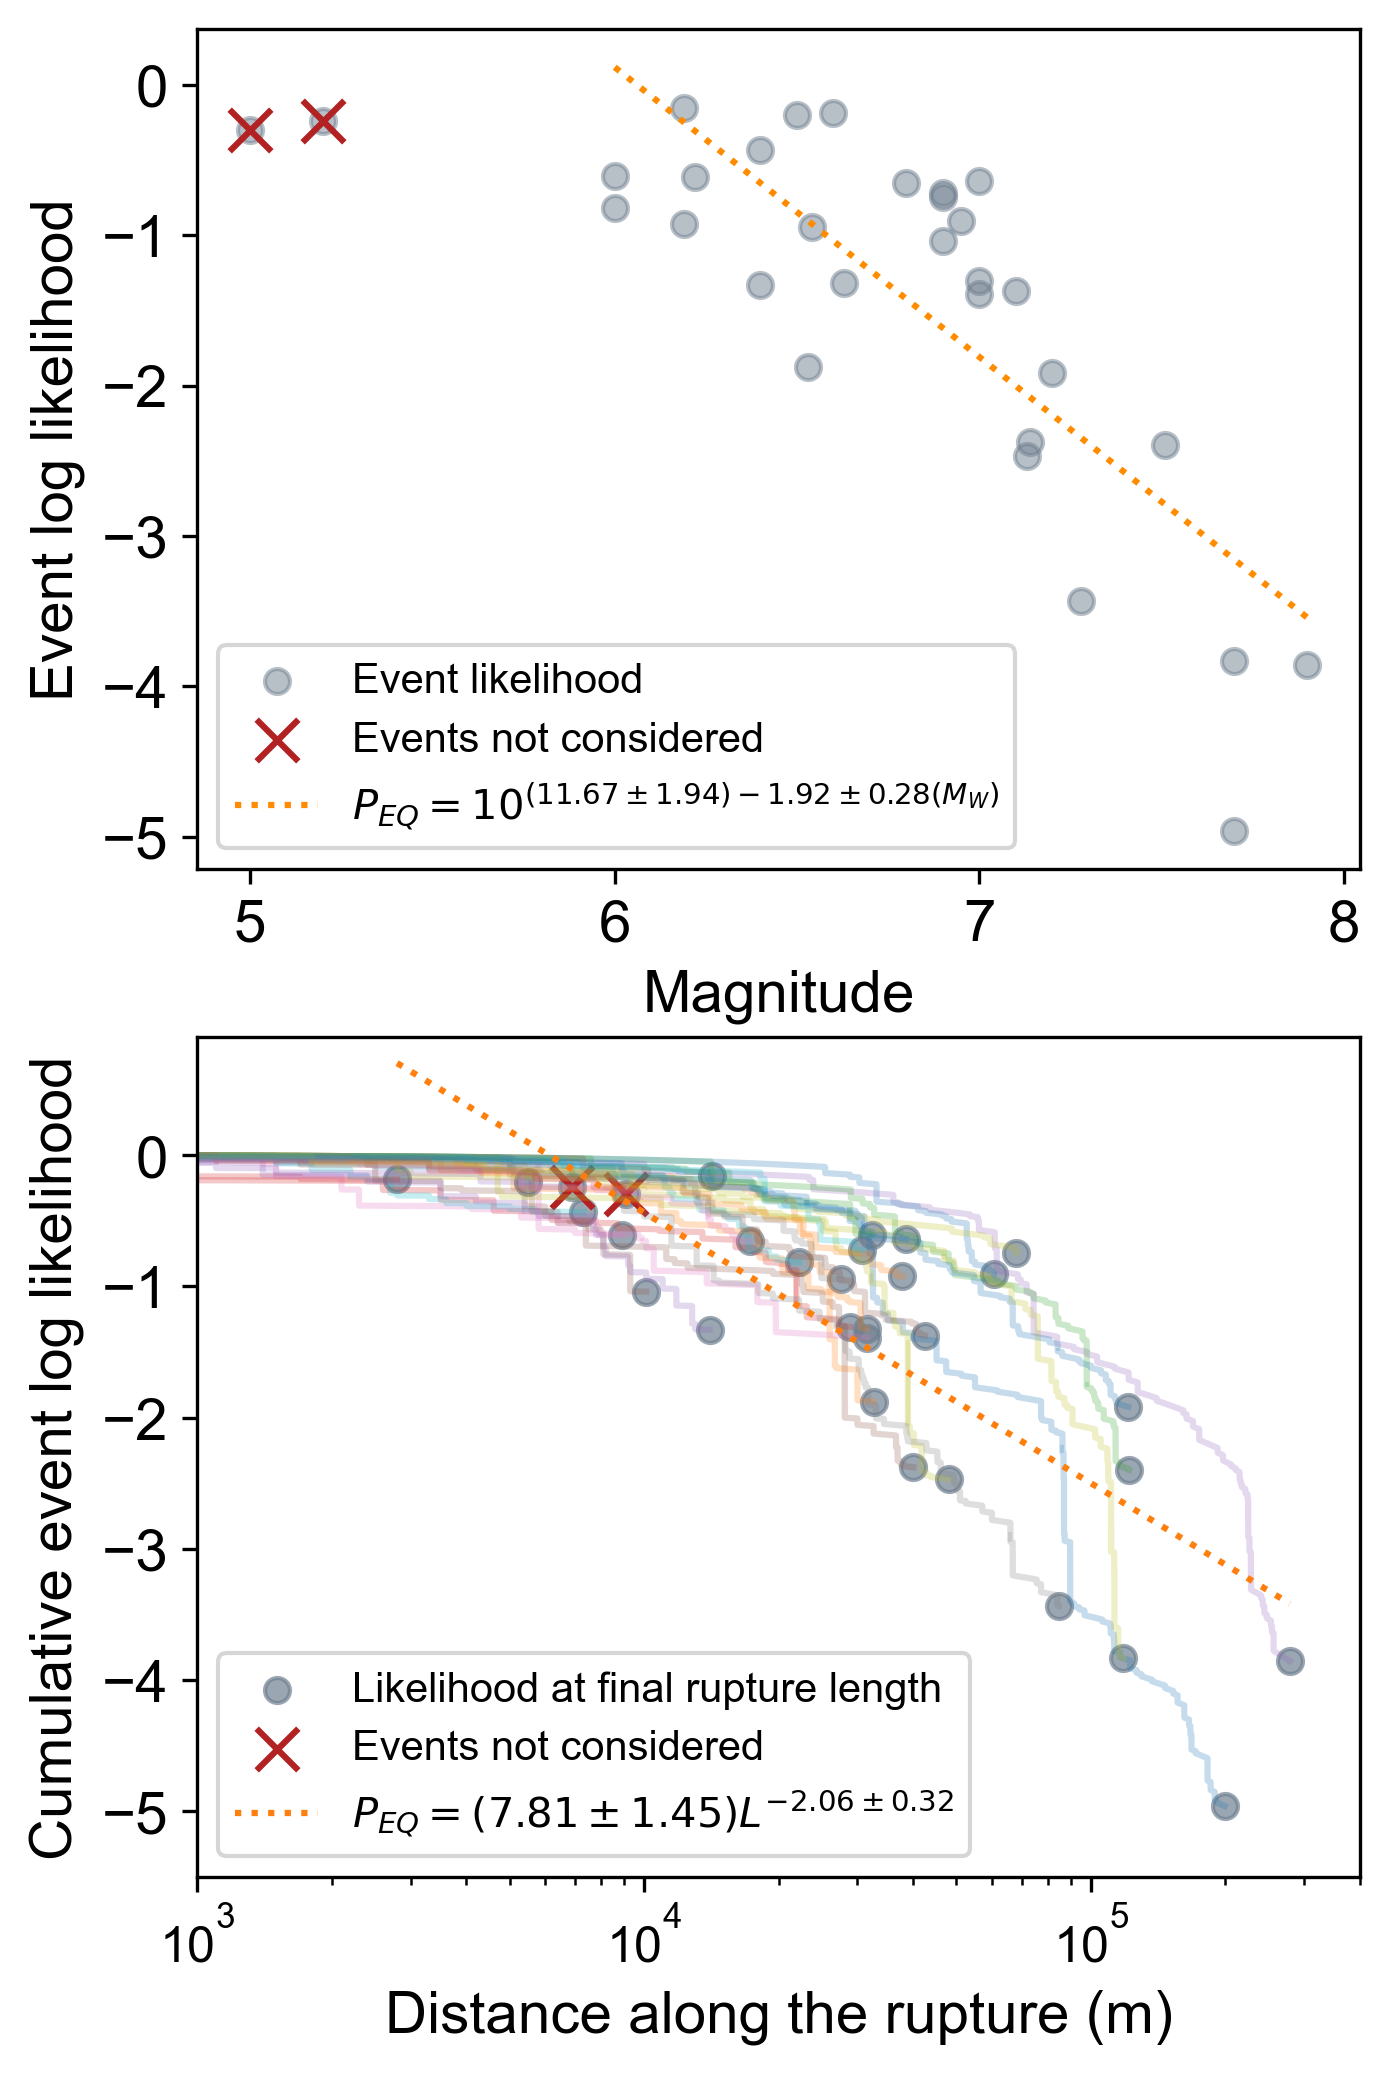

In [174]:
fig, ax= plt.subplots(2,1,figsize=(5,8),dpi=300)
ax[0].scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c='slategrey',alpha=0.5,label='Event likelihood')#,edgecolors='slategrey')

# for i in range(len(event_group)):
#     plt.annotate(event_group[i], (mag[i], event_likelihood[i]+np.log10(p_continue_straight)*SRL[i]),fontsize=8)

# ax[0].scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c=cumdisp,cmap='cividis',label='Number of segments',norm=mcolors.LogNorm())
# plt.colorbar(ax=ax[0])

idx = np.where(mag < 6) # remove outliers, i.e., events too small for proper rupture propagation to the surface
ax[0].scatter(mag[idx],event_likelihood[idx]+np.log10(p_continue_straight)*SRL[idx],c='firebrick',marker='x',s=100,label='Events not considered')

# for i in range(len(event_group)):
#     if np.isin(i, idx):
#         ax[0].annotate(event_group[i], (mag[i], event_likelihood[i]+np.log10(p_continue_straight)*SRL[i]),fontsize=8)


mag_del = np.delete(mag, idx)
cumdisp = np.delete(cumdisp,idx)
event_likelihood_del = np.delete(event_likelihood, idx)
SRL_del = np.delete(SRL, idx)

##### fit data with linear regression in semilog space (pwl bc mag is logged already)
all_info = stats.linregress(mag_del, event_likelihood_del+np.log10(p_continue_straight)*SRL_del)
# slope, intercept, r_value, p_value, std_err, intercept_stderr
print(all_info.slope,all_info.intercept, all_info.intercept_stderr)

# Define the x range for the line plot
x_range = np.linspace(min(mag_del), max(mag_del), 100)

# Calculate the y values for the line plot
y_range = all_info.slope * x_range + all_info.intercept

# Plot the data and the line fit with error bars
ax[0].plot(x_range, y_range, label=r"$P_{EQ} = 10^{(%.2f \pm %.2f) %.2f \pm  %.2f(M_W) }$" % (intercept,all_info.intercept_stderr,slope,all_info.stderr),linestyle=':',c='darkorange')
#ax[0].fill_between(x_range, y_range - std_err, y_range + std_err, alpha=0.2,color='darkorange',label='Standard error')

#ax[0].set_ylim([-5.5, 0.9])
ax[0].set_ylabel('Event log likelihood')
ax[0].set_xlabel('Magnitude')
ax[0].legend(fontsize=10)

# # Print the fitted parameters and errors
print("a = {:.3f} +/- {:.3f}".format(all_info.slope,all_info.stderr))
print("b = {:.3f} +/- {:.3f}".format(all_info.intercept, all_info.intercept_stderr))

######################################################## cumulative probability

lastpt = []
keeplikelihood = event_likelihood+np.log10(p_continue_straight)*SRL

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    subsetb = subsetb.reset_index(drop=True)
    subsetb['PR'] = subsetb['PR'].astype(float)

    gatelikelihood = subsetb['PR']
    gateloglikelihood = np.log10(subsetb['PR'])
    
    gateloc = subsetb['Location along rupture']
    subsetb['Approx_Location'] = subsetb['Location along rupture'].round().astype(int)

    SRL_event = subsetb['Total rupture length']   
    surf_length = SRL_event[0]
    surf_length = round(surf_length)
    probframe = pd.DataFrame()
    SRL_points = list(range(surf_length))
    new_rows = pd.DataFrame({'surf_length': SRL_points})
    probframe = probframe.append(new_rows, ignore_index=True)
    probframe['prob_straight_segment'] = p_continue_straight
    merged_df = pd.merge(probframe, subsetb, left_on='surf_length', right_on='Approx_Location', how='left')
    merged_df['prob'] = merged_df.apply(lambda row: row['PR'] if not pd.isnull(row['PR']) else row['prob_straight_segment'], axis=1)
    merged_df['cumulative_sum'] = np.log10(merged_df['prob']).cumsum()

    lastpt.append(max(SRL_points))

    # now we plot the data and fit the model:    
    sns.lineplot(data=merged_df,x=merged_df['surf_length'],y=merged_df['cumulative_sum'],palette="blend:#7AB,#EDA",alpha=0.25,ax=ax[1]) 

ax[1].scatter(lastpt,keeplikelihood,c='slategrey',alpha=0.7,label='Likelihood at final rupture length')
lastpt = np.array(lastpt)
keeplikelihood = np.array(keeplikelihood)
ax[1].scatter(lastpt[idx],keeplikelihood[idx],c='firebrick',marker='x',s=100,label='Events not considered')

# for i in range(len(event_group)):
#     if np.isin(i, idx):
#         ax[1].annotate(event_group[i], (lastpt[i], keeplikelihood[i]),fontsize=8)

#ax[1].set_xscale('log')
ax[1].set_ylabel('Cumulative event log likelihood')
ax[1].set_xlabel('Distance along the rupture (m)')
ax[1].set_ylim([-5.5, 0.9])
ax[1].set_xlim([10**3, 400*10**3])

lastpt = np.delete(lastpt,idx)
keeplikelihood = np.delete(keeplikelihood,idx)

# # Define the power-law function
def power_law(x, a, b):
     return b*np.log10(x)+a

# # Fit the data to the power-law function
popt, pcov = curve_fit(power_law, lastpt, keeplikelihood)

# # Calculate the errors
perr = np.sqrt(np.diag(pcov))

# # Print the fitted parameters and errors
print("a = {:.3f} +/- {:.3f}".format(popt[0], perr[0]))
print("b = {:.3f} +/- {:.3f}".format(popt[1], perr[1]))

# # Plot the power-law fit
xfit = np.linspace(min(lastpt),max(lastpt), 1000)
yfit = power_law(xfit, *popt)
ax[1].plot(xfit, yfit, label=r"$P_{EQ} = (%.2f \pm %.2f) L^{%.2f \pm  %.2f}$" % (popt[0],perr[0], popt[1],perr[1]),linestyle=':')

# # Show the plot
plt.xscale('log')
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='x', labelsize=12)
plt.savefig('GRL/mag_dependence_CDF_likelihood.pdf')
plt.show()

[2.23185355 1.00448148]


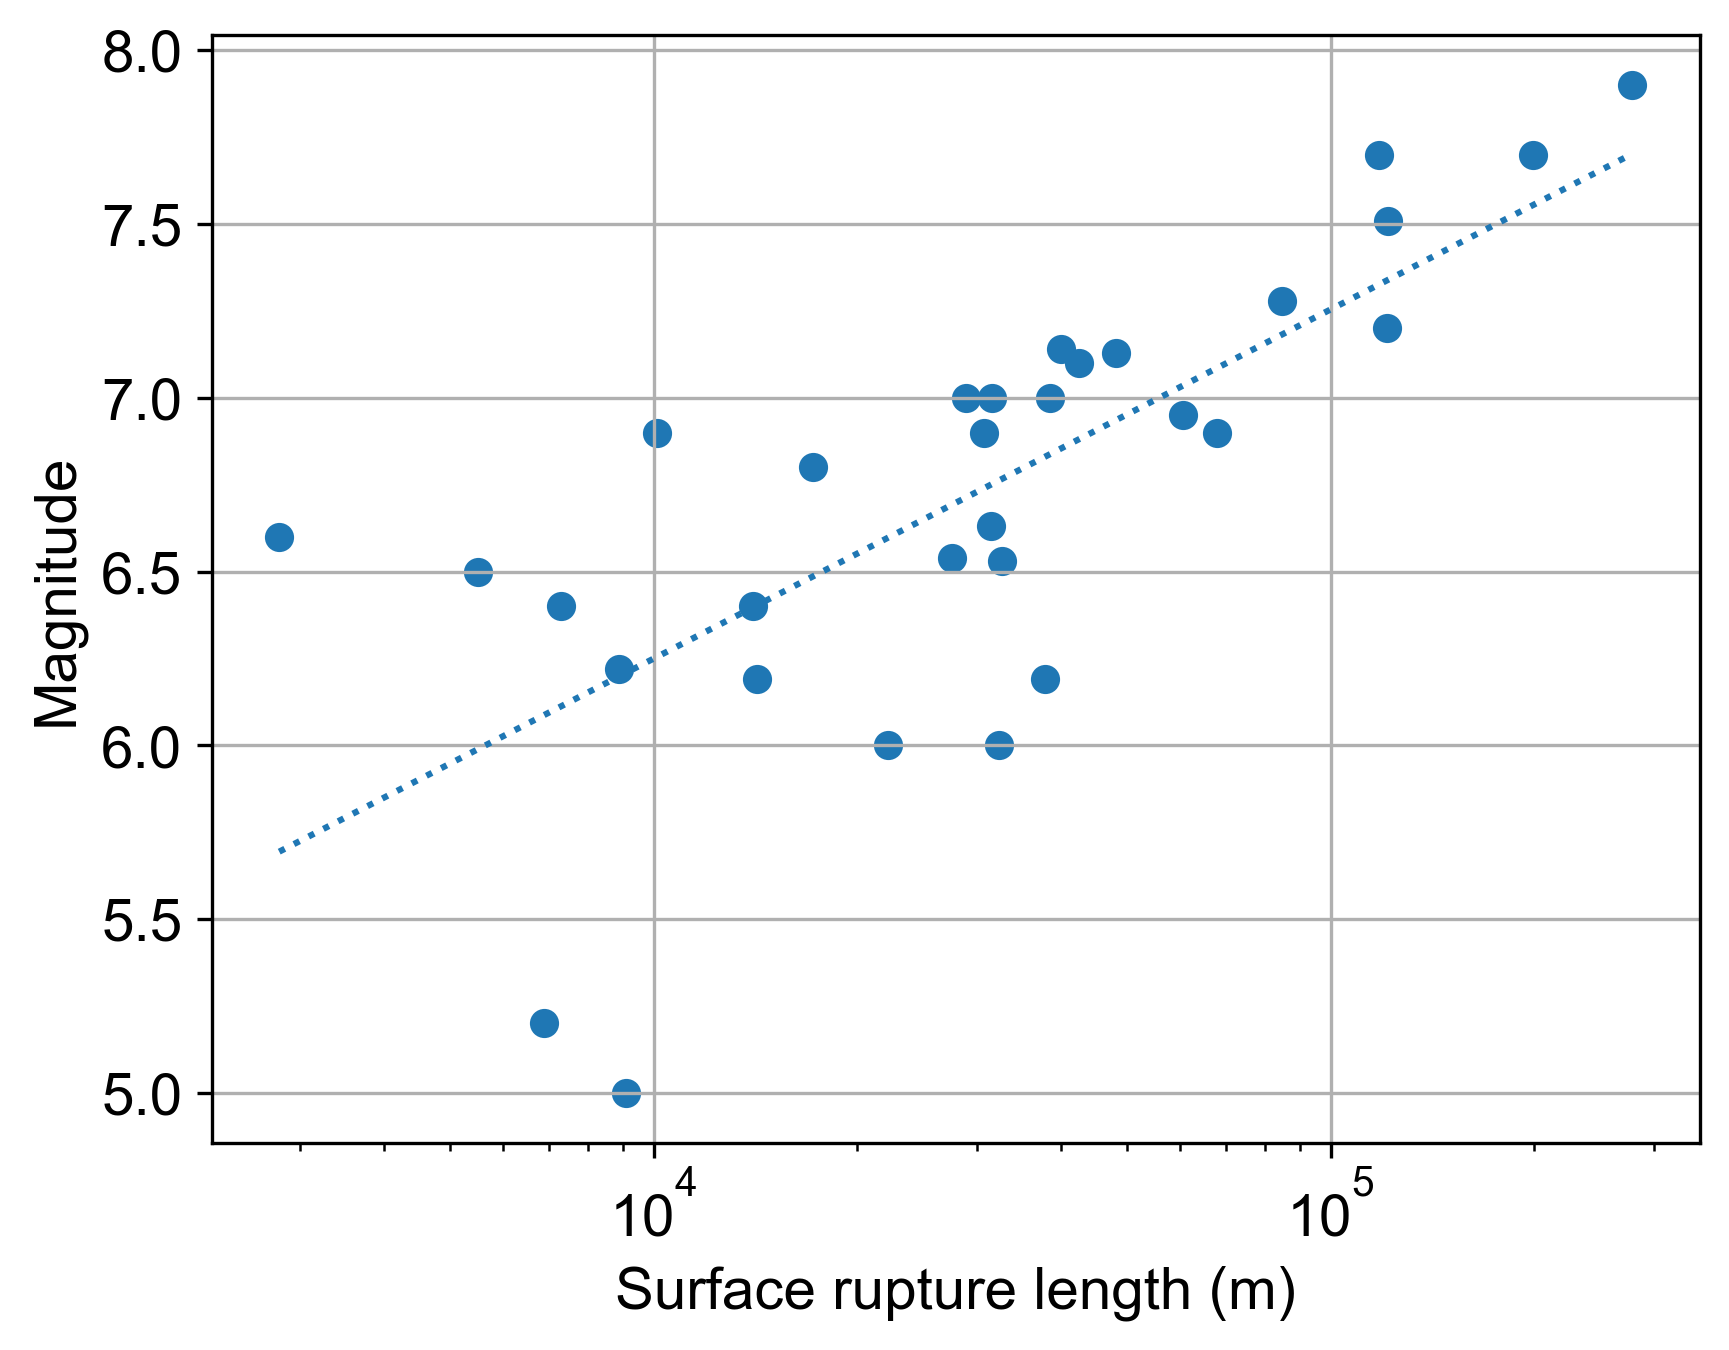

In [175]:
# for each event find magnitude and surface rupture length
plt.figure()
plt.scatter(SRL,mag)
plt.xlabel('Surface rupture length (m)')
plt.ylabel('Magnitude')
plt.xscale('log')
plt.grid()

# # Define the power-law function
def power_law(x, a, b):
     return b*np.log10(x)+a

# # Fit the data to the power-law function
popt, pcov = curve_fit(power_law, SRL, mag)


# # Plot the power-law fit
xfit = np.linspace(min(SRL),max(SRL), 1000)
yfit = power_law(xfit, *popt)
plt.plot(xfit, yfit,linestyle=':')

print(popt)


# Earthquake gates along rupture analysis

In [176]:
def gate_distribution_along_strike(groupid,type,length_or_angle,axesid,ylabel,palette):

    """
    This function plots the distribution of earthquake gates of a given type along the surface rupture
    
    """
        
    EQgate = grouped.get_group(groupid)

    if type == 'single':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        single = grouped_stress.get_group('single')
        feature = single['Length (m) or angle (deg)']
        normalized_loc = single['Normalized location']

    elif type == 'double':
        grouped_stress = EQgate.groupby(EQgate["Type (single or double)"])
        double = grouped_stress.get_group('double')
        feature = double['Length (m) or angle (deg)']
        normalized_loc = double['Normalized location']

    else:
        feature = EQgate['Length (m) or angle (deg)']
        normalized_loc = EQgate['Normalized location']
    
    if length_or_angle == 'length':
        yfeature = feature

    elif length_or_angle == 'angle':
        yfeature = feature

    else: 
        KeyError("Feature must include a length or an angle")

    # now we plot the data and fit the model:    
    sns.scatterplot(data=EQgate,x=normalized_loc,y=yfeature,hue=EQgate['Breached or unbreached'],palette=palette, edgecolor='none',alpha=0.6, ax=axesid,legend='')
    axesid.set_ylabel(ylabel)
    if max(yfeature)>90:
        axesid.set_yscale('log')
    axesid.set_xlabel('Normalized distance along the rupture')


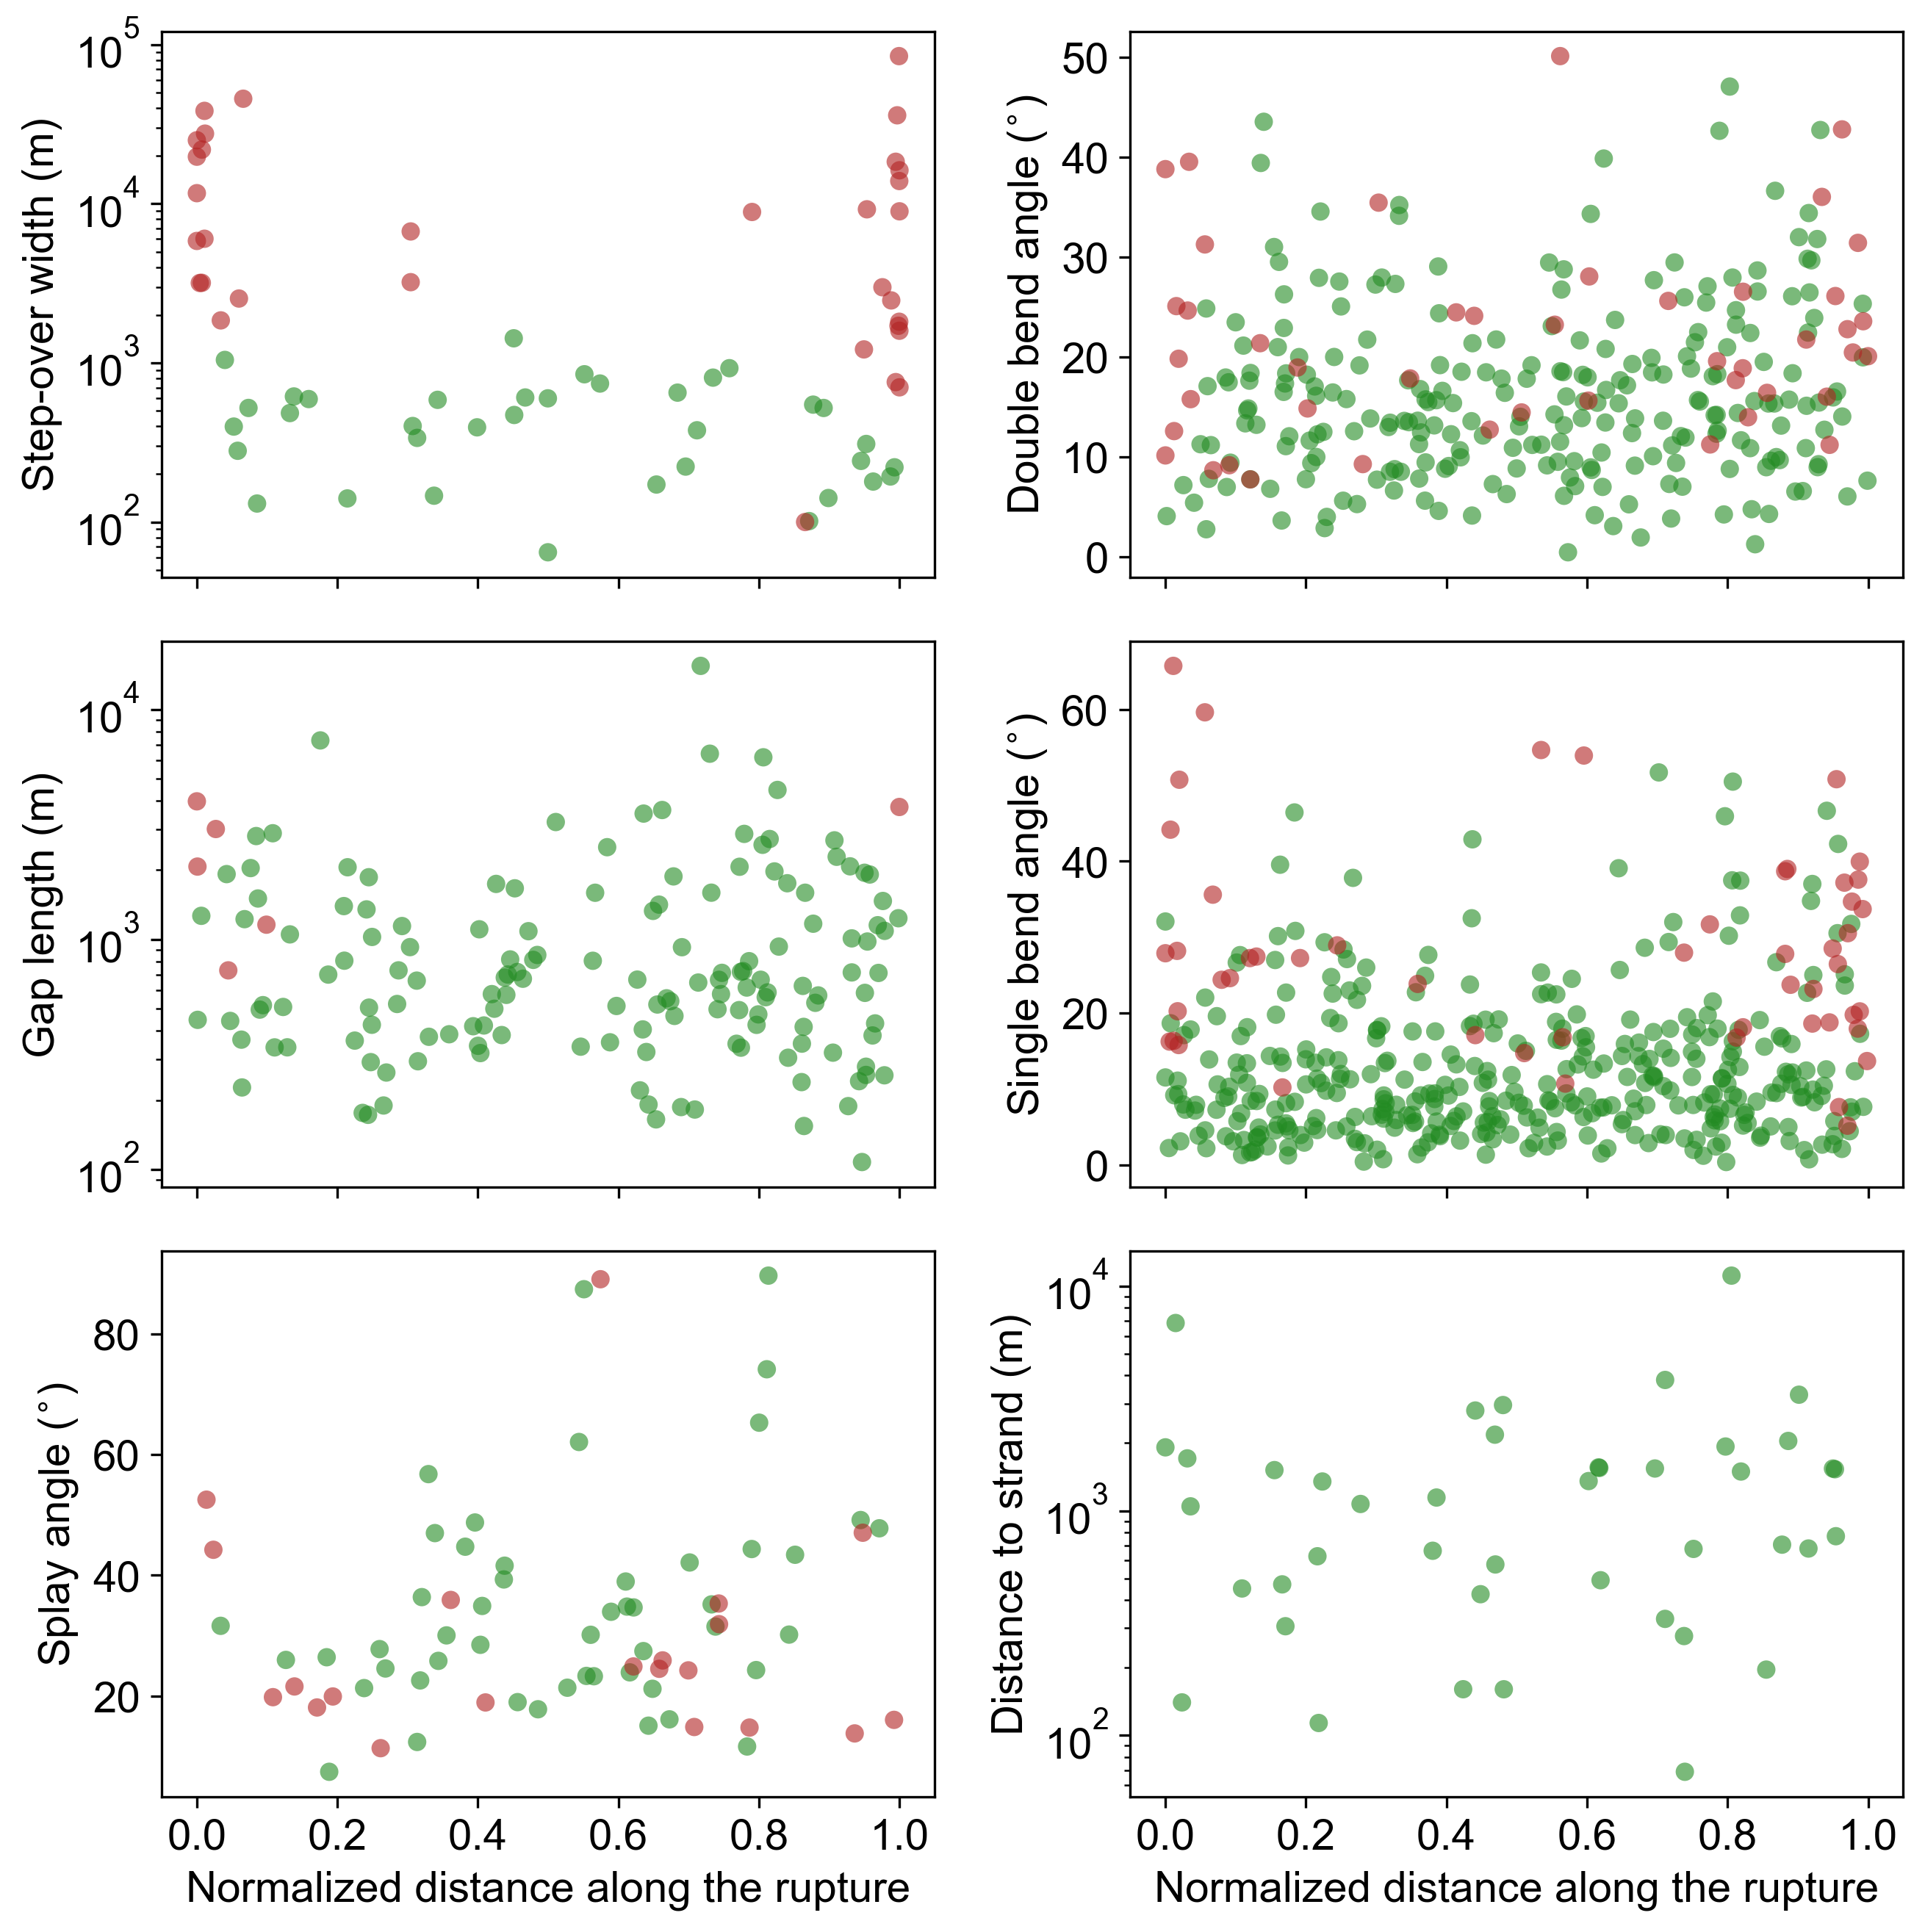

In [177]:
fig, axes = plt.subplots(3,2,figsize=(9, 9),sharex=True,dpi=300)
palette = {'breached': 'forestgreen', 'unbreached': 'firebrick'}
gate_distribution_along_strike('stepover','none','length',axes[0,0],'Step-over width (m)',palette)
gate_distribution_along_strike('bend','double','angle',axes[0,1],'Double bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike('bend','single','angle',axes[1,1],'Single bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike('gap','none','length',axes[1,0],'Gap length (m)',palette)
gate_distribution_along_strike('splay','none','angle',axes[2,0],'Splay angle ($^{\circ}$)',palette)
gate_distribution_along_strike('strand','none','length',axes[2,1],'Distance to strand (m)',palette)
plt.tight_layout()
plt.savefig('GRL/Normalized_dist_size.pdf')
plt.show()


## Comparison to previous studies

In [178]:
def calculate_center(numbers):
    center_values = []
    for i in range(len(numbers) - 1):
        center = (numbers[i] + numbers[i + 1]) / 2.0
        center_values.append(center)
    return center_values

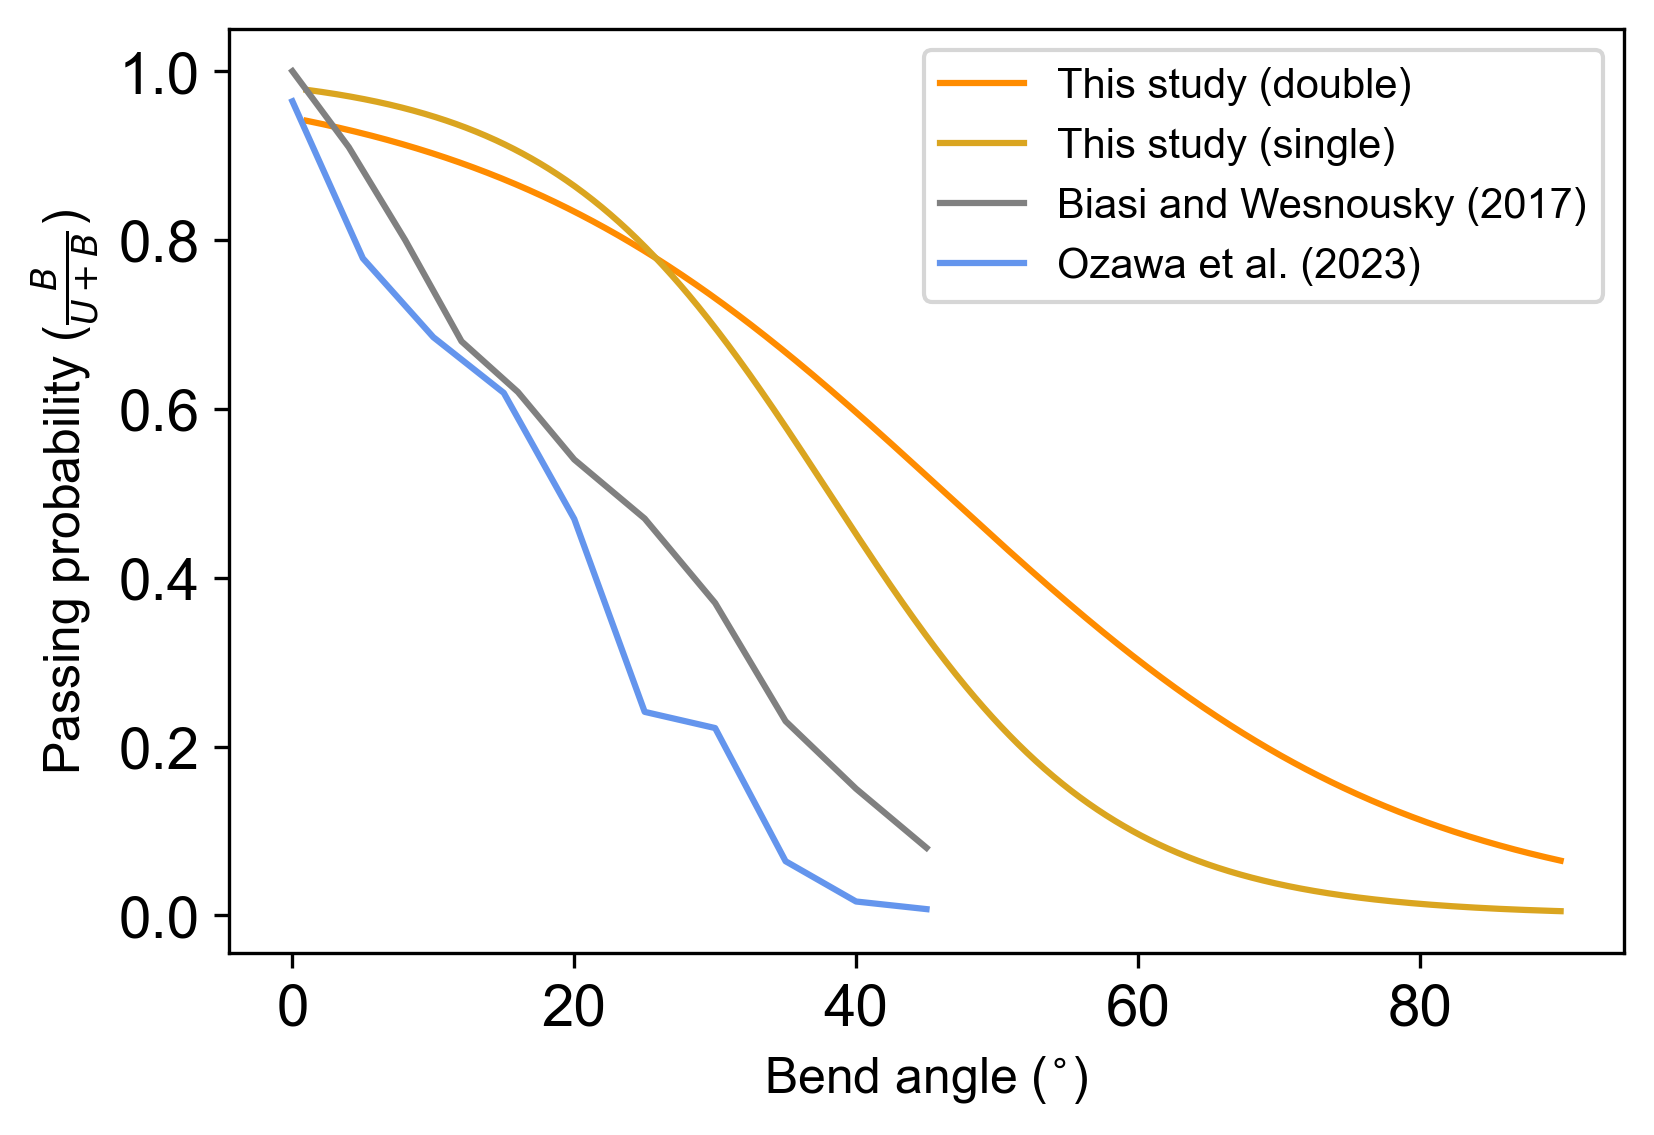

In [179]:
group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
double = selectB.get_group('double')
double['Bin'] = pd.cut(double['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
double['Bin Middle'] = double['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = double[double['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

# Count the occurrences of 'unbreached' for each value of 'Bin Middle'
unbreached_counts = double[double['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)

plt.figure(figsize=(6,4),dpi=300)
#plt.plot(unique_values,ratio,c='darkorange',label='This study (double)')
x = np.atleast_2d(np.linspace(1, 90, 1000)).T
proba_double = log_bend_double.predict_proba(x)[:,0]
proba_single = log_bend_single.predict_proba(x)[:,0]

plt.plot(x,proba_double,c='darkorange',label='This study (double)')
plt.plot(x,proba_single,c='goldenrod',label='This study (single)')
group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
single = selectB.get_group('single')
single['Bin'] = pd.cut(single['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
single['Bin Middle'] = single['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = single[single['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

# Count the occurrences of 'unbreached' for each value of 'Bin Middle'
unbreached_counts = single[single['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)
#plt.plot(unique_values,ratio,c='goldenrod',label='This study (single)')

# load data from Biasi and Wesnousky (2017) and Okawa et al. (2023)
Bend_angle_Biasi = np.array([0, 4, 8, 12, 16, 20, 25, 30, 35, 40, 45])
PP_Biasi = np.array([1, 0.91, 0.80, 0.68, 0.62, 0.54, 0.47, 0.37, 0.23, 0.15, 0.08])

Bend_angle_Ozawa = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
PP_Ozawa = np.array([0.96428571, 0.77829376, 0.68489335, 0.61890165, 0.46959471, 0.24105128, 0.22185883, 0.06410775, 0.01640081, 0.00738151])

plt.plot(Bend_angle_Biasi, PP_Biasi,'gray',label='Biasi and Wesnousky (2017)')
plt.plot(Bend_angle_Ozawa,PP_Ozawa,'cornflowerblue', label='Ozawa et al. (2023)')
plt.ylabel(r'Passing probability ($\frac{B}{U+B}$)',fontsize=12)
plt.xlabel(r'Bend angle ($^{\circ}$)',fontsize=12)
plt.legend(fontsize=10)
plt.savefig('GRL/bendPPcomparisons.pdf')

# Earthquake gate size vs distance to event epicenter and maximum slip location

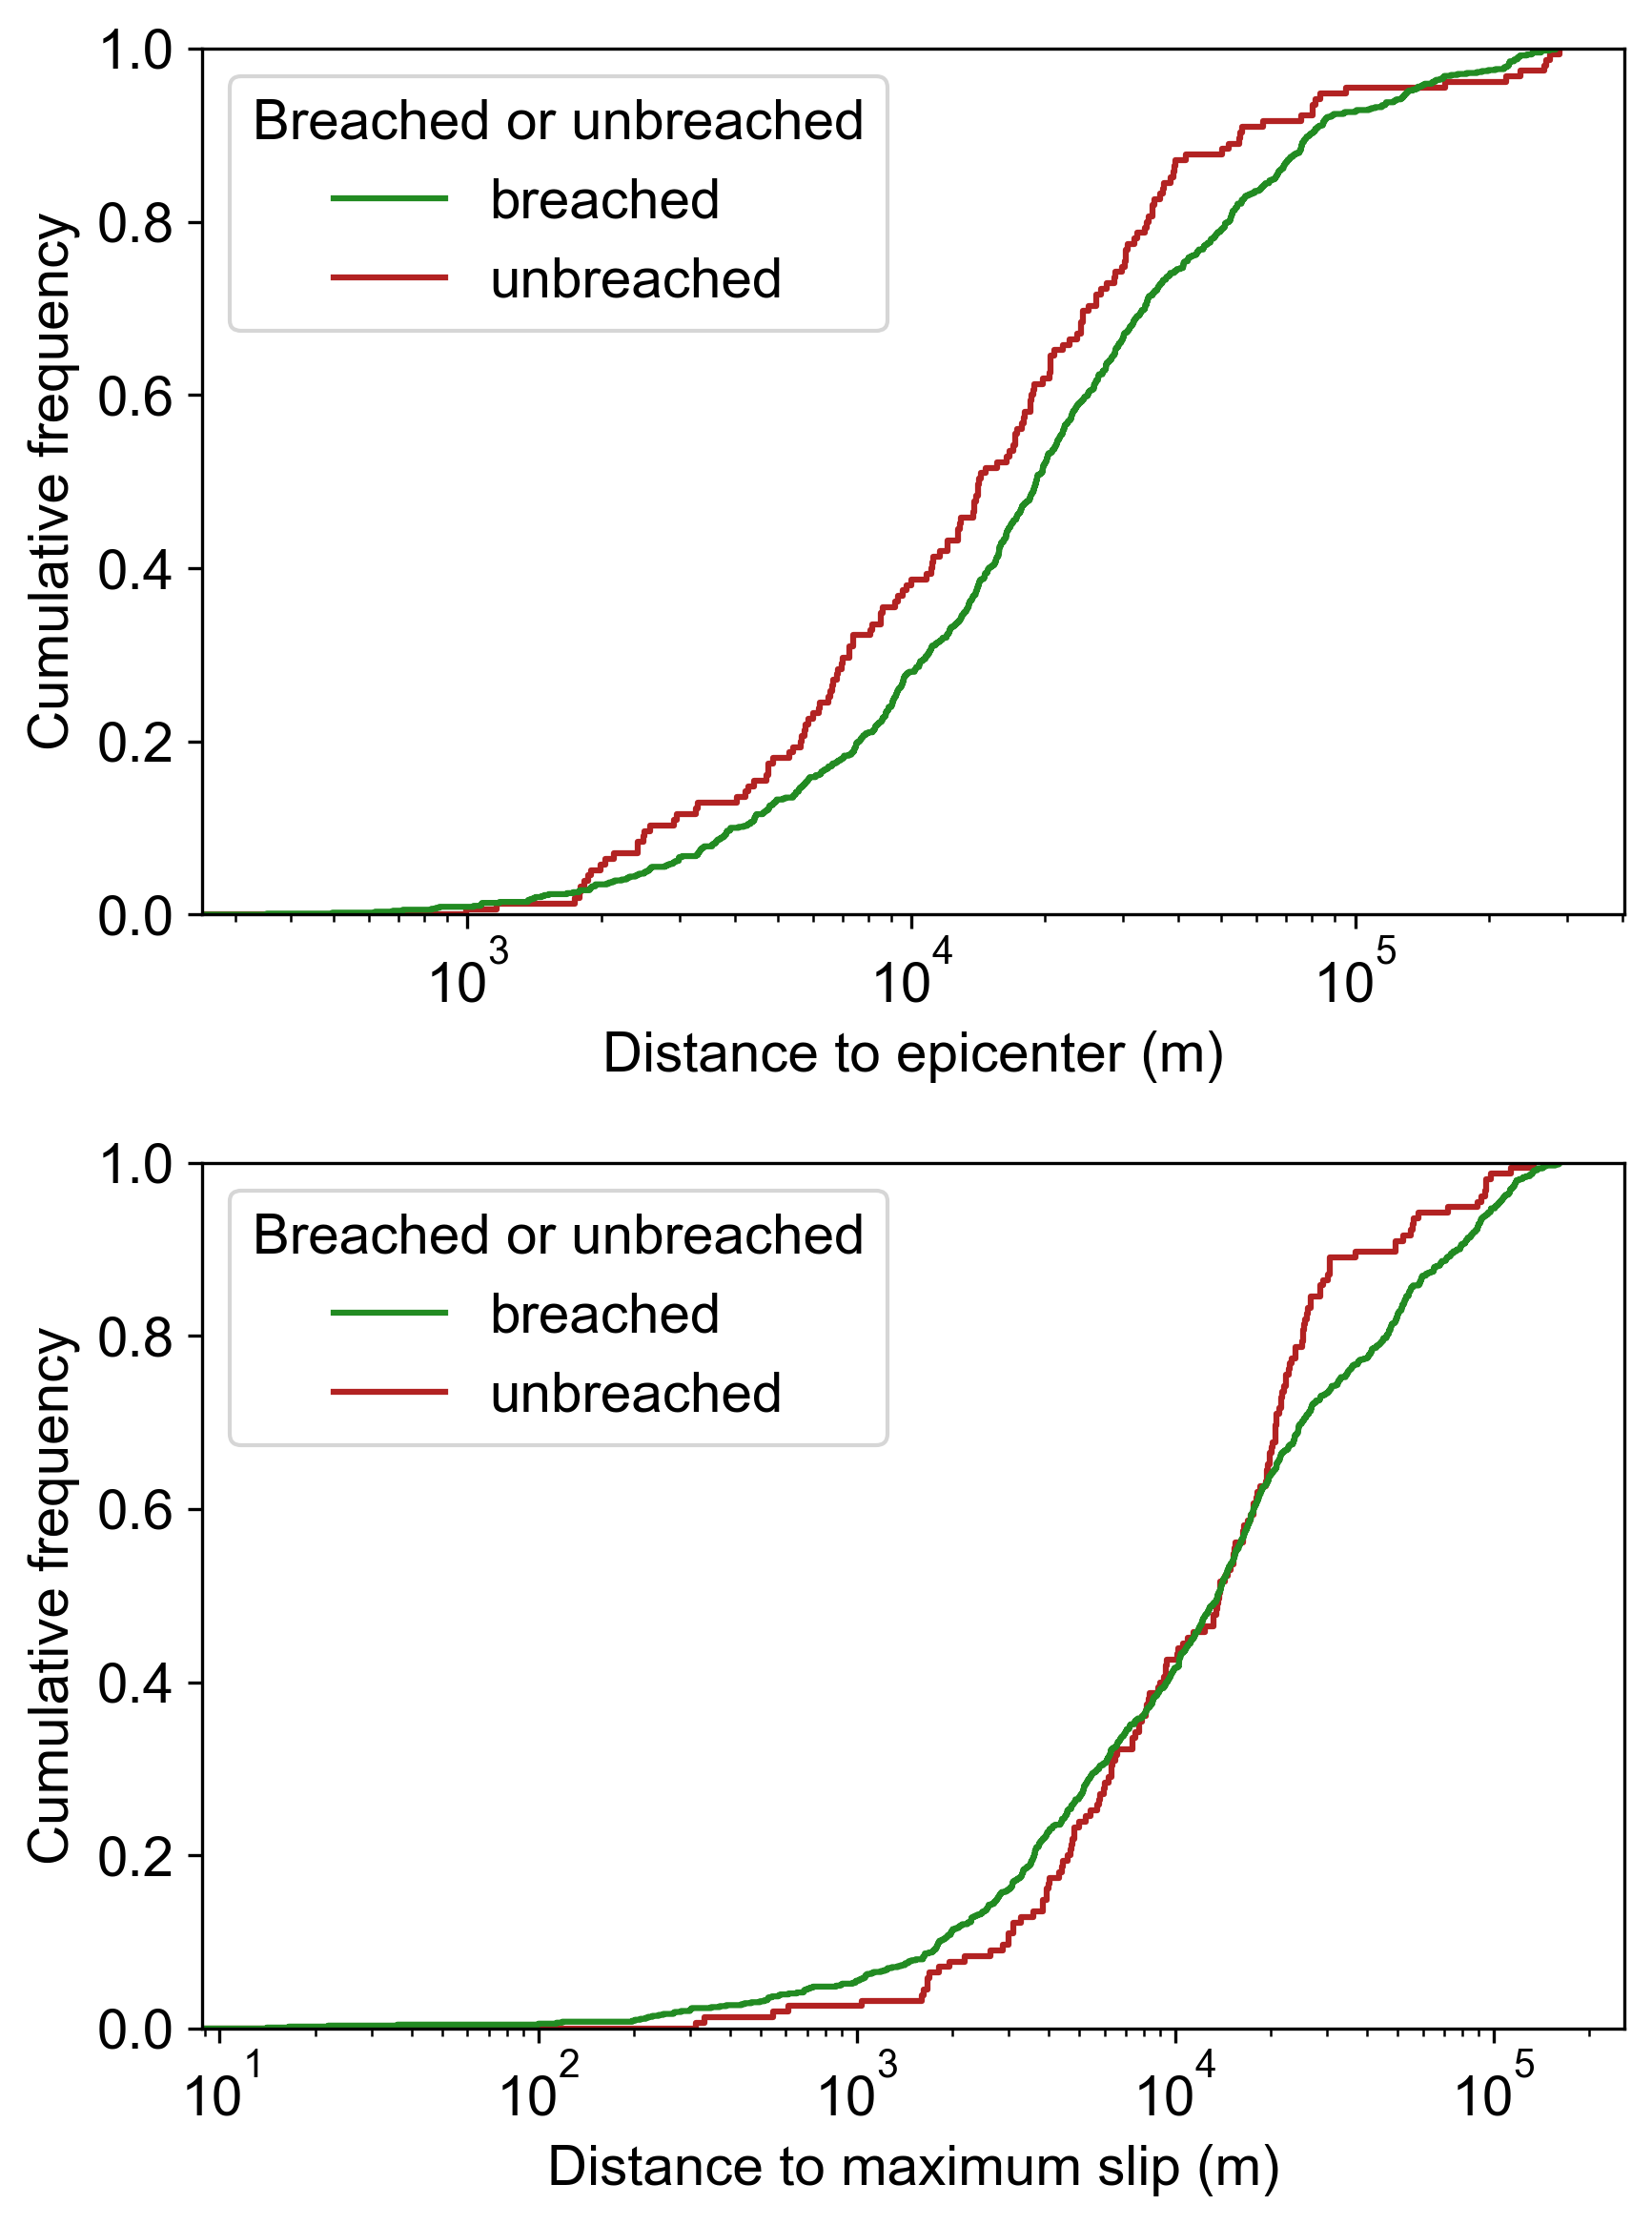

In [180]:
fig, axes = plt.subplots(2,1,figsize=(6,8),dpi=300)

# Define custom colors for 'Breached' and 'Unbreached'
custom_palette = {"breached": "forestgreen", "unbreached": "firebrick"}

# Use the 'ecdf' function in Seaborn with custom colors
sns.ecdfplot(data=data, x="Distance to epicenter", hue="Breached or unbreached", palette=custom_palette,ax=axes[0])

# Label the axes and add a legend
axes[0].set_xlabel('Distance to epicenter (m)')
axes[0].set_ylabel('Cumulative frequency')
axes[0].set_xscale('log')
# Create custom legend handles and labels
# Remove the legend title (set it to an empty string)

# Define custom colors for 'Breached' and 'Unbreached'
custom_palette = {"breached": "forestgreen", "unbreached": "firebrick"}

# Use the 'ecdf' function in Seaborn with custom colors
sns.ecdfplot(data=data, x="Distance to max slip", hue="Breached or unbreached", palette=custom_palette,ax=axes[1])

# Label the axes and add a legend
axes[1].set_xlabel('Distance to maximum slip (m)')
axes[1].set_ylabel('Cumulative frequency')
axes[1].set_xscale('log')

# Create custom legend handles and labels
# Remove the legend title (set it to an empty string)

plt.tight_layout()
plt.savefig('GRL/epicenter_maxslip_distance_CDF.pdf')
# Show the CDF plot
plt.show()